In [ ]:

from google.colab import drive

drive.mount("/content/drive", force_remount=False)

Mounted at /content/drive


In [ ]:
!pip install -q --upgrade --force-reinstall numpy pandas==2.2.2 matplotlib nibabel
!pip uninstall -y torch torchvision torchaudio -qq
!pip install -q torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu121
!pip install -q nnunetv2==2.4.2 monai nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 421.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 

In [ ]:

import os, shutil, subprocess, textwrap, warnings, logging, sys
from pathlib import Path
from tqdm import tqdm
import numpy as np, nibabel as nib, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

DRV          = Path("/content/drive/MyDrive/data")
SRC_DIR      = DRV / "gan_data" / "Synthetic_dataset_random_labels"
OUT_DIR      = DRV / "Baseline_result"; OUT_DIR.mkdir(exist_ok=True)
DATASET      = "Dataset232_BraTS_2023_rGANs"
TRAINER      = "nnUNetTrainer__nnUNetPlans__3d_fullres"
FOLDS        = ["0", "1", "2", "3", "4"]
MODALITY     = "flair"
MOD_MAP      = {"t1ce":"0000", "t1":"0001", "t2":"0002", "flair":"0003"}

os.environ.update({
    "nnUNet_raw":          "/content/nnUNet_raw",
    "nnUNet_preprocessed": "/content/nnUNet_preprocessed",
    "nnUNet_results":      "/content/nnUNet_results",
    "RESULTS_FOLDER":      "/content/nnUNet_results",
})

log_fp = OUT_DIR / "baseline.log"
logger = logging.getLogger("baseline"); logger.setLevel(logging.INFO); logger.handlers.clear()
for h in (logging.StreamHandler(sys.stdout), logging.FileHandler(log_fp, encoding="utf-8")):
    h.setFormatter(logging.Formatter("%(asctime)s  %(message)s")); logger.addHandler(h)
logger.info("=== new session ===")

csv_fp = OUT_DIR / "metrics_summary.csv"
if csv_fp.exists():
    df_prev = pd.read_csv(csv_fp)
    done_cases = set(df_prev["case"])
else:
    df_prev = pd.DataFrame(columns=["case", "dice", "iou"])
    csv_fp.write_text("case,dice,iou\n")
    done_cases = set()

all_cases  = sorted([d.name for d in SRC_DIR.iterdir() if d.is_dir()])
todo_cases = [c for c in all_cases if c not in done_cases]
logger.info(f"total={len(all_cases)}  finished={len(done_cases)}  to_run={len(todo_cases)}")
if not todo_cases:
    logger.info("Nothing left to process."); raise SystemExit

RAW_TS = Path(os.environ["nnUNet_raw"]) / DATASET / "imagesTs"
shutil.rmtree(RAW_TS, ignore_errors=True); RAW_TS.mkdir(parents=True, exist_ok=True)
for c in tqdm(todo_cases, desc="link images"):
    for mod, idx in MOD_MAP.items():
        src = SRC_DIR/c/f"{c}-scan_{mod}.nii.gz"
        if src.exists():
            (RAW_TS/f"{c}_{idx}.nii.gz").symlink_to(src.resolve())

PREP = Path(os.environ["nnUNet_preprocessed"])/DATASET; PREP.mkdir(parents=True, exist_ok=True)
for fn in ["dataset.json","plans.json"]:
    if not (PREP/fn).exists():
        shutil.copy(DRV/fn, PREP/fn)

RES = Path(os.environ["nnUNet_results"])/DATASET/TRAINER
for k in FOLDS:
    fd = RES/f"fold_{k}"; fd.mkdir(parents=True, exist_ok=True)
    if not (fd/"checkpoint_final.pth").exists():
        shutil.copy(DRV/f"fold_{k}"/"checkpoint_final.pth", fd/"checkpoint_final.pth")
    for fn in ["dataset.json","plans.json"]:
        if not (RES/fn).exists():
            shutil.copy(DRV/fn, RES/fn)

# inference
PRED_DIR = OUT_DIR/"preds"; shutil.rmtree(PRED_DIR, ignore_errors=True); PRED_DIR.mkdir(exist_ok=True)
device = "cuda" if Path("/usr/bin/nvidia-smi").exists() else "cpu"
cmd = (
    f"nnUNetv2_predict -i {RAW_TS} -o {PRED_DIR} "
    f"-d {DATASET} -c 3d_fullres -f {' '.join(FOLDS)} -device {device}"
)
logger.info("nnUNetv2_predict launched…"); subprocess.run(textwrap.dedent(cmd), shell=True, check=True)

# helper functions
def dice_iou(p, g):
    tp=(p & g).sum(); fp=(p & ~g).sum(); fn=(~p & g).sum()
    return 2*tp/(2*tp+fp+fn+1e-8), tp/(tp+fp+fn+1e-8)

def append_csv(case, d, i):
    with open(csv_fp, "a") as f:
        f.write(f"{case},{d:.6f},{i:.6f}\n"); f.flush(); os.fsync(f.fileno())


pred_files = sorted(PRED_DIR.glob("*.nii.gz"))
for idx, pred_fp in enumerate(tqdm(pred_files, desc="score"), 1):
    case = pred_fp.stem
    gt_fp  = SRC_DIR/case/f"{case}-seg.nii.gz"
    img_fp = SRC_DIR/case/f"{case}-scan_{MODALITY}.nii.gz"
    if not (gt_fp.exists() and img_fp.exists()):
        continue

    pred = nib.load(pred_fp).get_fdata().astype(bool)
    gt   = nib.load(gt_fp ).get_fdata().astype(bool)
    d,i  = dice_iou(pred, gt)

    logger.info(f"[{idx:>4}/{len(pred_files)}] {case:<35} Dice={d:.4f}  IoU={i:.4f}")
    append_csv(case, d, i)

    img = nib.load(img_fp).get_fdata(); z=img.shape[2]//2
    img_n=(img[:,:,z]-img[:,:,z].min())/(img[:,:,z].ptp()+1e-8)
    fig,ax=plt.subplots(1,3,figsize=(10,3),dpi=120)
    ax[0].imshow(img_n.T,cmap='gray',origin='lower'); ax[0].imshow(pred[:,:,z].T,cmap='Reds',alpha=.35,origin='lower'); ax[0].axis('off')
    ax[1].imshow(img_n.T,cmap='gray',origin='lower'); ax[1].imshow(gt  [:,:,z].T,cmap='Greens',alpha=.35,origin='lower'); ax[1].axis('off')
    ov=np.zeros((*pred[:,:,z].T.shape,4))
    ov[(pred[:,:,z].T)&(gt[:,:,z].T) ]=[1,0,0,.4]
    ov[(~pred[:,:,z].T)&(gt[:,:,z].T)]=[0,1,0,.4]
    ov[(pred[:,:,z].T)&(~gt[:,:,z].T)]=[0,0,1,.4]
    ax[2].imshow(img_n.T,cmap='gray',origin='lower'); ax[2].imshow(ov,origin='lower'); ax[2].axis('off')
    fig.savefig(OUT_DIR/f"{case}_overlay.png",bbox_inches="tight"); plt.close(fig)

df_all = pd.read_csv(csv_fp)
logger.info(f"Session finished – cumulative average  Dice={df_all.dice.mean():.4f}  IoU={df_all.iou.mean():.4f}")

2025-07-22 03:11:40,993  === new session ===


INFO:baseline:=== new session ===


2025-07-22 03:11:42,730  total=296  finished=230  to_run=66


INFO:baseline:total=296  finished=230  to_run=66
link images: 100%|██████████| 66/66 [00:00<00:00, 311.53it/s]


2025-07-22 03:11:43,465  nnUNetv2_predict launched…


INFO:baseline:nnUNetv2_predict launched…


CalledProcessError: Command 'nnUNetv2_predict -i /content/nnUNet_raw/Dataset232_BraTS_2023_rGANs/imagesTs -o /content/drive/MyDrive/data/Baseline_result/preds -d Dataset232_BraTS_2023_rGANs -c 3d_fullres -f 0 1 2 3 4 -device cuda' returned non-zero exit status 1.

In [ ]:
import os
import math
import time
import shutil
import subprocess
import textwrap
import warnings
import logging
import sys
from pathlib import Path
from tqdm import tqdm
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ———— 路径 & 参数配置 ————
DRV       = Path("/content/drive/MyDrive/data")
SRC_DIR   = DRV / "gan_data" / "Synthetic_dataset_random_labels"
OUT_DIR   = DRV / "Baseline_result";    OUT_DIR.mkdir(exist_ok=True)

DATASET   = "Dataset232_BRaTS_2023_rGANs"
TRAINER   = "nnUNetTrainer__nnUNetPlans__3d_fullres"
FOLDS     = ["0", "1", "2", "3", "4"]
MODALITY  = "flair"
MOD_MAP   = {"t1ce":"0000", "t1":"0001", "t2":"0002", "flair":"0003"}

# nnU-Net 环境变量
os.environ.update({
    "nnUNet_raw":          "/content/nnUNet_raw",
    "nnUNet_preprocessed": "/content/nnUNet_preprocessed",
    "nnUNet_results":      "/content/nnUNet_results",
    "RESULTS_FOLDER":      "/content/nnUNet_results",
})

# ———— 日志设置 ————
log_fp = OUT_DIR / "baseline.log"
logger = logging.getLogger("baseline")
logger.setLevel(logging.INFO)
logger.handlers.clear()
for h in (logging.StreamHandler(sys.stdout), logging.FileHandler(log_fp, encoding="utf-8")):
    h.setFormatter(logging.Formatter("%(asctime)s  %(message)s"))
    logger.addHandler(h)
logger.info("=== new session ===")

# ———— 准备度量 CSV ————
csv_fp = OUT_DIR / "metrics_summary.csv"
if csv_fp.exists():
    df_prev    = pd.read_csv(csv_fp)
    done_cases = set(df_prev["case"])
else:
    df_prev    = pd.DataFrame(columns=["case", "dice", "iou", "inf_seconds"])
    csv_fp.write_text("case,dice,iou,inf_seconds\n")
    done_cases = set()

# ———— 选取待推理的 sample （这里示例为所有 todo_cases，可按需改为最后15%） ————
all_cases  = sorted([d.name for d in SRC_DIR.iterdir() if d.is_dir()])
# 例如取最后 15%，若想全部推理可直接用 todo_cases = all_cases
n_last     = max(1, math.ceil(len(all_cases) * 0.15))
todo_cases = all_cases[-n_last:]
logger.info(f"总样本数={len(all_cases)}  本次推理={len(todo_cases)}")

# ———— 链接原始影像 到 nnUNet_raw ————
RAW_TS = Path(os.environ["nnUNet_raw"]) / DATASET / "imagesTs"
shutil.rmtree(RAW_TS, ignore_errors=True)
RAW_TS.mkdir(parents=True, exist_ok=True)
for case in tqdm(todo_cases, desc="link images"):
    for mod, idx in MOD_MAP.items():
        src = SRC_DIR / case / f"{case}-scan_{mod}.nii.gz"
        if src.exists():
            (RAW_TS / f"{case}_{idx}.nii.gz").symlink_to(src.resolve())

# ———— 拷贝 dataset.json & plans.json 到 preprocessed ————
PREP = Path(os.environ["nnUNet_preprocessed"]) / DATASET
PREP.mkdir(parents=True, exist_ok=True)
for fn in ("dataset.json","plans.json"):
    src_fn = DRV / fn
    dst_fn = PREP / fn
    if src_fn.exists() and not dst_fn.exists():
        shutil.copy(src_fn, dst_fn)
        logger.info(f"Copied {fn} to preprocessed: {dst_fn}")

# ———— 拷贝 dataset.json & plans.json 到模型输出目录 ————
RES_BASE = Path(os.environ["nnUNet_results"]) / DATASET / TRAINER
RES_BASE.mkdir(parents=True, exist_ok=True)
for fn in ("dataset.json","plans.json"):
    src_fn = DRV / fn
    dst_fn = RES_BASE / fn
    if src_fn.exists():
        shutil.copy(src_fn, dst_fn)
        logger.info(f"Copied {fn} to model folder: {dst_fn}")
    else:
        logger.error(f"Source {fn} missing: {src_fn}")

# ———— 强制拷贝 checkpoint & 完整性校验 ————
for k in FOLDS:
    dst_fold = RES_BASE / f"fold_{k}"
    dst_fold.mkdir(parents=True, exist_ok=True)

    src_ckpt = DRV / f"fold_{k}" / "checkpoint_final.pth"
    dst_ckpt = dst_fold / "checkpoint_final.pth"

    if not src_ckpt.exists():
        logger.error(f"[Fold {k}] 源 checkpoint 不存在: {src_ckpt}")
        continue
    src_size = src_ckpt.stat().st_size
    if src_size == 0:
        logger.error(f"[Fold {k}] 源 checkpoint 文件为空")
        continue

    logger.info(f"[Fold {k}] 源 checkpoint 大小: {src_size/1e6:.2f} MB — 开始拷贝")
    shutil.copy(src_ckpt, dst_ckpt)

    if dst_ckpt.exists():
        dst_size = dst_ckpt.stat().st_size
        logger.info(f"[Fold {k}] 目标 checkpoint 大小: {dst_size/1e6:.2f} MB")
        if dst_size != src_size:
            logger.error(f"[Fold {k}] 拷贝后大小与源不匹配！")
    else:
        logger.error(f"[Fold {k}] 拷贝失败，目标文件不存在: {dst_ckpt}")

# ———— 推理 ————
PRED_DIR = OUT_DIR / "preds"
shutil.rmtree(PRED_DIR, ignore_errors=True)
PRED_DIR.mkdir(exist_ok=True)

device = "cuda" if Path("/usr/bin/nvidia-smi").exists() else "cpu"
cmd = (
    f"nnUNetv2_predict -i {RAW_TS} -o {PRED_DIR} "
    f"-d {DATASET} -c 3d_fullres -f {' '.join(FOLDS)} -device {device}"
)
logger.info("nnUNetv2_predict launched…")
start_time = time.time()
proc = subprocess.run(textwrap.dedent(cmd), shell=True, capture_output=True, text=True)
elapsed = time.time() - start_time

if proc.returncode != 0:
    logger.error(f"nnUNetv2_predict 退出码：{proc.returncode}")
    logger.error(f"--- stdout ---\n{proc.stdout}")
    logger.error(f"--- stderr ---\n{proc.stderr}")
    sys.exit(1)

logger.info(f"推理完成，用时 {elapsed:.2f} 秒")

# ———— 评估函数 & 记录 ————
def dice_iou(p, g):
    tp = (p & g).sum(); fp = (p & ~g).sum(); fn = (~p & g).sum()
    return 2*tp/(2*tp+fp+fn+1e-8), tp/(tp+fp+fn+1e-8)

def append_csv(case, d, i, t):
    with open(csv_fp, "a") as f:
        f.write(f"{case},{d:.6f},{i:.6f},{t:.2f}\n")

# ———— 打分 & 保存叠图 ————
pred_files = sorted(PRED_DIR.glob("*.nii.gz"))
for idx, pred_fp in enumerate(tqdm(pred_files, desc="score"), 1):
    case  = pred_fp.stem
    gt_fp = SRC_DIR / case / f"{case}-seg.nii.gz"
    img_fp= SRC_DIR / case / f"{case}-scan_{MODALITY}.nii.gz"
    if not (gt_fp.exists() and img_fp.exists()):
        continue

    pred = nib.load(pred_fp).get_fdata().astype(bool)
    gt   = nib.load(gt_fp ).get_fdata().astype(bool)
    d, i = dice_iou(pred, gt)
    inf_t = elapsed / len(pred_files)

    logger.info(f"[{idx}/{len(pred_files)}] {case}  Dice={d:.4f}  IoU={i:.4f}  inf={inf_t:.2f}s")
    append_csv(case, d, i, inf_t)

    img = nib.load(img_fp).get_fdata(); z = img.shape[2]//2
    img_n = (img[:,:,z] - img[:,:,z].min()) / (img[:,:,z].ptp() + 1e-8)

    fig, axes = plt.subplots(1, 3, figsize=(10,3), dpi=120)
    axes[0].imshow(img_n.T, origin='lower', cmap='gray')
    axes[0].imshow(pred[:,:,z].T, alpha=.35, origin='lower', cmap='Reds')
    axes[0].axis('off')
    axes[1].imshow(img_n.T, origin='lower', cmap='gray')
    axes[1].imshow(gt[:,:,z].T, alpha=.35, origin='lower', cmap='Greens')
    axes[1].axis('off')
    ov = np.zeros((*pred[:,:,z].T.shape, 4))
    ov[(pred[:,:,z].T)&(gt[:,:,z].T)]   = [1,0,0,0.4]
    ov[(~pred[:,:,z].T)&(gt[:,:,z].T)]  = [0,1,0,0.4]
    ov[(pred[:,:,z].T)&(~gt[:,:,z].T)]  = [0,0,1,0.4]
    axes[2].imshow(img_n.T, origin='lower', cmap='gray')
    axes[2].imshow(ov,      origin='lower')
    axes[2].axis('off')

    fig.savefig(OUT_DIR / f"{case}_overlay.png", bbox_inches="tight")
    plt.close(fig)

# ———— 汇总 ————
df_all = pd.read_csv(csv_fp)
logger.info(f"Session finished – cumulative average  Dice={df_all.dice.mean():.4f}  IoU={df_all.iou.mean():.4f}")

2025-07-22 03:20:53,181  === new session ===


INFO:baseline:=== new session ===


2025-07-22 03:20:53,227  总样本数=296  本次推理=45


INFO:baseline:总样本数=296  本次推理=45
link images: 100%|██████████| 45/45 [00:00<00:00, 296.11it/s]

2025-07-22 03:20:53,392  Copied dataset.json to model folder: /content/nnUNet_results/Dataset232_BRaTS_2023_rGANs/nnUNetTrainer__nnUNetPlans__3d_fullres/dataset.json



INFO:baseline:Copied dataset.json to model folder: /content/nnUNet_results/Dataset232_BRaTS_2023_rGANs/nnUNetTrainer__nnUNetPlans__3d_fullres/dataset.json


2025-07-22 03:20:53,408  Copied plans.json to model folder: /content/nnUNet_results/Dataset232_BRaTS_2023_rGANs/nnUNetTrainer__nnUNetPlans__3d_fullres/plans.json


INFO:baseline:Copied plans.json to model folder: /content/nnUNet_results/Dataset232_BRaTS_2023_rGANs/nnUNetTrainer__nnUNetPlans__3d_fullres/plans.json


2025-07-22 03:20:53,410  [Fold 0] 源 checkpoint 大小: 246.92 MB — 开始拷贝


INFO:baseline:[Fold 0] 源 checkpoint 大小: 246.92 MB — 开始拷贝


2025-07-22 03:20:53,766  [Fold 0] 目标 checkpoint 大小: 246.92 MB


INFO:baseline:[Fold 0] 目标 checkpoint 大小: 246.92 MB


2025-07-22 03:20:53,768  [Fold 1] 源 checkpoint 大小: 246.92 MB — 开始拷贝


INFO:baseline:[Fold 1] 源 checkpoint 大小: 246.92 MB — 开始拷贝


2025-07-22 03:20:54,116  [Fold 1] 目标 checkpoint 大小: 246.92 MB


INFO:baseline:[Fold 1] 目标 checkpoint 大小: 246.92 MB


2025-07-22 03:20:54,118  [Fold 2] 源 checkpoint 大小: 246.92 MB — 开始拷贝


INFO:baseline:[Fold 2] 源 checkpoint 大小: 246.92 MB — 开始拷贝


2025-07-22 03:20:54,416  [Fold 2] 目标 checkpoint 大小: 246.92 MB


INFO:baseline:[Fold 2] 目标 checkpoint 大小: 246.92 MB


2025-07-22 03:20:54,418  [Fold 3] 源 checkpoint 大小: 246.92 MB — 开始拷贝


INFO:baseline:[Fold 3] 源 checkpoint 大小: 246.92 MB — 开始拷贝


2025-07-22 03:20:54,690  [Fold 3] 目标 checkpoint 大小: 246.92 MB


INFO:baseline:[Fold 3] 目标 checkpoint 大小: 246.92 MB


2025-07-22 03:20:54,692  [Fold 4] 源 checkpoint 大小: 246.92 MB — 开始拷贝


INFO:baseline:[Fold 4] 源 checkpoint 大小: 246.92 MB — 开始拷贝


2025-07-22 03:20:54,951  [Fold 4] 目标 checkpoint 大小: 246.92 MB


INFO:baseline:[Fold 4] 目标 checkpoint 大小: 246.92 MB


2025-07-22 03:20:54,957  nnUNetv2_predict launched…


INFO:baseline:nnUNetv2_predict launched…


2025-07-22 03:25:30,598  nnUNetv2_predict 退出码：1


ERROR:baseline:nnUNetv2_predict 退出码：1


2025-07-22 03:25:30,600  --- stdout ---

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 45 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 45 cases that I would like to predict

Predicting BraTS-GLI-00824-000_fake_label_48:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done with BraTS-GLI-00824-000_fake_label_48

Predicting BraTS-GLI-00824-000_fake_label_49:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done with BraTS-GLI-00824-000_fake_label_49

Pre

ERROR:baseline:--- stdout ---

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 45 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 45 cases that I would like to predict

Predicting BraTS-GLI-00824-000_fake_label_48:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done with BraTS-GLI-00824-000_fake_label_48

Predicting BraTS-GLI-00824-000_fake_label_49:
perform_everything_on_device: True
sending off prediction to background worker for resampling and export
done with BraTS-GLI-00824-000_fake_label_49

Predicting Br

2025-07-22 03:25:30,601  --- stderr ---
/usr/local/lib/python3.11/dist-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 

ERROR:baseline:--- stderr ---
/usr/local/lib/python3.11/dist-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoin

SystemExit: 1

In [ ]:
# ===============================================================
#  Dice / IoU scorer
#  • reads prediction masks  (.nii.gz)   →  /Baseline_result/preds
#  • reads ground-truth masks (.nii.gz)  →  /gan_data/Synthetic_dataset_random_labels/<case>/<case>-seg.nii.gz
#  • computes Dice & IoU for every case
#  • prints metrics live + appends to  Baseline_result/metrics_summary.csv
#  • optional mid-slice overlay PNG for quick visual check
#  (CPU-only; no GPU or deep-learning libs required)
# ===============================================================

import os, logging, sys, warnings, shutil
from pathlib import Path
from tqdm import tqdm
import nibabel as nib, numpy as np, pandas as pd, matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ---------------------------------------------------------------
#  0. paths  ─ (edit if your Drive layout differs)
# ---------------------------------------------------------------
DRV_ROOT   = Path("/content/drive/MyDrive/data")            # Google Drive root
SRC_DIR    = DRV_ROOT / "gan_data" / "Synthetic_dataset_random_labels"  # GT masks
PRED_DIR   = DRV_ROOT / "Baseline_result" / "preds"         # predicted masks
OUT_DIR    = DRV_ROOT / "Baseline_result"                   # where CSV / PNG / log go
OUT_DIR.mkdir(exist_ok=True, parents=True)

MODALITY   = "flair"     # which scan to use for overlay PNG (can change)

# ---------------------------------------------------------------
#  1. logger  (stdout + file)
# ---------------------------------------------------------------
log_fp = OUT_DIR / "metric_only.log"
logger = logging.getLogger("metric"); logger.setLevel(logging.INFO); logger.handlers.clear()
for h in (logging.StreamHandler(sys.stdout), logging.FileHandler(log_fp, encoding="utf-8")):
    h.setFormatter(logging.Formatter("%(asctime)s  %(message)s")); logger.addHandler(h)
logger.info("=== metric-only session started ===")

# ---------------------------------------------------------------
#  2. CSV init  (append if exists, else create header)
# ---------------------------------------------------------------
csv_fp = OUT_DIR / "metrics_summary.csv"
if csv_fp.exists():
    done = {r.split(",")[0] for r in open(csv_fp).read().strip().splitlines()[1:]}
else:
    csv_fp.write_text("case,dice,iou\n"); done = set()

# ---------------------------------------------------------------
#  3. helper fns
# ---------------------------------------------------------------
def dice_iou(pred, gt):
    """binary masks → Dice & IoU"""
    tp = (pred & gt).sum()
    fp = (pred & ~gt).sum()
    fn = (~pred & gt).sum()
    dice = 2*tp / (2*tp + fp + fn + 1e-8)
    iou  = tp   / (tp   + fp + fn + 1e-8)
    return dice, iou

def append_csv(case, d, j):
    """stream metrics to CSV (flush+fsync = Drive-safe)"""
    with open(csv_fp, "a") as f:
        f.write(f"{case},{d:.6f},{j:.6f}\n")
        f.flush(); os.fsync(f.fileno())

# ---------------------------------------------------------------
#  4. iterate predictions → score
# ---------------------------------------------------------------
pred_files = sorted(PRED_DIR.glob("*.nii.gz"))
logger.info(f"Found {len(pred_files)} prediction files")

for idx, fp in enumerate(tqdm(pred_files, desc="score"), 1):
    case = fp.name.replace(".nii.gz", "")          # strip full suffix
    if case in done:
        continue                                   # already in CSV

    gt_fp  = SRC_DIR / case / f"{case}-seg.nii.gz"
    img_fp = SRC_DIR / case / f"{case}-scan_{MODALITY}.nii.gz"

    if not gt_fp.exists():
        logger.warning(f"{case}: ground-truth not found → skip")
        continue

    pred = nib.load(fp).get_fdata().astype(bool)
    gt   = nib.load(gt_fp).get_fdata().astype(bool)
    d, j = dice_iou(pred, gt)

    logger.info(f"[{idx}/{len(pred_files)}] {case:<35}  Dice={d:.4f}  IoU={j:.4f}")
    append_csv(case, d, j)

    # ---------- optional PNG overlay ----------
    # ---------- optional PNG overlay ----------
    if img_fp.exists():
        img = nib.load(img_fp).get_fdata()
        z   = img.shape[2] // 2                       # middle slice index
        img_slice = img[:, :, z]
        img_n = (img_slice - img_slice.min()) / (np.ptp(img_slice) + 1e-8)

        fig, ax = plt.subplots(1, 3, figsize=(10, 3), dpi=120)

        ax[0].imshow(img_n.T, cmap="gray", origin="lower")
        ax[0].imshow(pred[:, :, z].T, cmap="Reds",   alpha=.35, origin="lower")
        ax[0].axis("off")

        ax[1].imshow(img_n.T, cmap="gray", origin="lower")
        ax[1].imshow(gt  [:, :, z].T, cmap="Greens", alpha=.35, origin="lower")
        ax[1].axis("off")

        ov = np.zeros((*pred[:, :, z].T.shape, 4))
        ov[(pred[:, :, z].T) & (gt[:, :, z].T)]  = [1, 0, 0, .4]  # TP  red
        ov[(~pred[:, :, z].T) & (gt[:, :, z].T)] = [0, 1, 0, .4]  # FN  green
        ov[(pred[:, :, z].T) & (~gt[:, :, z].T)] = [0, 0, 1, .4]  # FP  blue

        ax[2].imshow(img_n.T, cmap="gray", origin="lower")
        ax[2].imshow(ov, origin="lower")
        ax[2].axis("off")

        fig.savefig(OUT_DIR / f"{case}_overlay.png", bbox_inches="tight")
        plt.close(fig)

#  5. summary
df = pd.read_csv(csv_fp)
logger.info(f"Finished – Avg Dice={df.dice.mean():.4f}  IoU={df.iou.mean():.4f}")

2025-07-10 02:24:22,814  === metric-only session started ===


INFO:metric:=== metric-only session started ===


2025-07-10 02:24:22,830  Found 230 prediction files


INFO:metric:Found 230 prediction files
score:   0%|          | 0/230 [00:00<?, ?it/s]

2025-07-10 02:24:23,430  [11/230] BraTS-GLI-00819-000_real_label_68    Dice=0.8998  IoU=0.8178


INFO:metric:[11/230] BraTS-GLI-00819-000_real_label_68    Dice=0.8998  IoU=0.8178
score:   5%|▍         | 11/230 [00:01<00:30,  7.15it/s]

2025-07-10 02:24:24,986  [12/230] BraTS-GLI-00819-000_real_label_7     Dice=0.8777  IoU=0.7821


INFO:metric:[12/230] BraTS-GLI-00819-000_real_label_7     Dice=0.8777  IoU=0.7821
score:   5%|▌         | 12/230 [00:03<01:12,  3.00it/s]

2025-07-10 02:24:27,271  [13/230] BraTS-GLI-00819-000_real_label_72    Dice=0.8988  IoU=0.8163


INFO:metric:[13/230] BraTS-GLI-00819-000_real_label_72    Dice=0.8988  IoU=0.8163
score:   6%|▌         | 13/230 [00:05<02:04,  1.75it/s]

2025-07-10 02:24:28,762  [14/230] BraTS-GLI-00819-000_real_label_73    Dice=0.8683  IoU=0.7673


INFO:metric:[14/230] BraTS-GLI-00819-000_real_label_73    Dice=0.8683  IoU=0.7673
score:   6%|▌         | 14/230 [00:06<02:35,  1.39it/s]

2025-07-10 02:24:30,195  [15/230] BraTS-GLI-00819-000_real_label_76    Dice=0.8597  IoU=0.7540


INFO:metric:[15/230] BraTS-GLI-00819-000_real_label_76    Dice=0.8597  IoU=0.7540
score:   7%|▋         | 15/230 [00:08<03:07,  1.14it/s]

2025-07-10 02:24:31,761  [16/230] BraTS-GLI-00819-000_real_label_78    Dice=0.8764  IoU=0.7800


INFO:metric:[16/230] BraTS-GLI-00819-000_real_label_78    Dice=0.8764  IoU=0.7800
score:   7%|▋         | 16/230 [00:09<03:39,  1.03s/it]

2025-07-10 02:24:33,287  [17/230] BraTS-GLI-00819-000_real_label_81    Dice=0.8816  IoU=0.7883


INFO:metric:[17/230] BraTS-GLI-00819-000_real_label_81    Dice=0.8816  IoU=0.7883
score:   7%|▋         | 17/230 [00:11<04:03,  1.14s/it]

2025-07-10 02:24:36,018  [18/230] BraTS-GLI-00819-000_real_label_84    Dice=0.8983  IoU=0.8153


INFO:metric:[18/230] BraTS-GLI-00819-000_real_label_84    Dice=0.8983  IoU=0.8153
score:   8%|▊         | 18/230 [00:14<05:29,  1.55s/it]

2025-07-10 02:24:37,681  [19/230] BraTS-GLI-00819-000_real_label_85    Dice=0.8983  IoU=0.8154


INFO:metric:[19/230] BraTS-GLI-00819-000_real_label_85    Dice=0.8983  IoU=0.8154
score:   8%|▊         | 19/230 [00:15<05:35,  1.59s/it]

2025-07-10 02:24:39,394  [20/230] BraTS-GLI-00819-000_real_label_86    Dice=0.8828  IoU=0.7902


INFO:metric:[20/230] BraTS-GLI-00819-000_real_label_86    Dice=0.8828  IoU=0.7902
score:   9%|▊         | 20/230 [00:17<05:42,  1.63s/it]

2025-07-10 02:24:41,004  [21/230] BraTS-GLI-00819-000_real_label_87    Dice=0.9192  IoU=0.8504


INFO:metric:[21/230] BraTS-GLI-00819-000_real_label_87    Dice=0.9192  IoU=0.8504
score:   9%|▉         | 21/230 [00:19<05:36,  1.61s/it]

2025-07-10 02:24:42,714  [22/230] BraTS-GLI-00819-000_real_label_88    Dice=0.8901  IoU=0.8019


INFO:metric:[22/230] BraTS-GLI-00819-000_real_label_88    Dice=0.8901  IoU=0.8019
score:  10%|▉         | 22/230 [00:21<06:04,  1.75s/it]

2025-07-10 02:24:44,857  [23/230] BraTS-GLI-00819-000_real_label_89    Dice=0.8786  IoU=0.7835


INFO:metric:[23/230] BraTS-GLI-00819-000_real_label_89    Dice=0.8786  IoU=0.7835
score:  10%|█         | 23/230 [00:23<06:17,  1.82s/it]

2025-07-10 02:24:47,038  [24/230] BraTS-GLI-00819-000_real_label_91    Dice=0.8974  IoU=0.8139


INFO:metric:[24/230] BraTS-GLI-00819-000_real_label_91    Dice=0.8974  IoU=0.8139
score:  10%|█         | 24/230 [00:25<06:12,  1.81s/it]

2025-07-10 02:24:48,450  [25/230] BraTS-GLI-00819-000_real_label_92    Dice=0.8783  IoU=0.7829


INFO:metric:[25/230] BraTS-GLI-00819-000_real_label_92    Dice=0.8783  IoU=0.7829
score:  11%|█         | 25/230 [00:26<05:48,  1.70s/it]

2025-07-10 02:24:49,837  [26/230] BraTS-GLI-00819-000_real_label_93    Dice=0.8941  IoU=0.8084


INFO:metric:[26/230] BraTS-GLI-00819-000_real_label_93    Dice=0.8941  IoU=0.8084
score:  11%|█▏        | 26/230 [00:28<05:47,  1.70s/it]

2025-07-10 02:24:52,061  [27/230] BraTS-GLI-00819-000_real_label_94    Dice=0.8900  IoU=0.8019


INFO:metric:[27/230] BraTS-GLI-00819-000_real_label_94    Dice=0.8900  IoU=0.8019
score:  12%|█▏        | 27/230 [00:30<05:56,  1.76s/it]

2025-07-10 02:24:53,549  [28/230] BraTS-GLI-00819-000_real_label_96    Dice=0.9148  IoU=0.8430


INFO:metric:[28/230] BraTS-GLI-00819-000_real_label_96    Dice=0.9148  IoU=0.8430
score:  12%|█▏        | 28/230 [00:31<05:45,  1.71s/it]

2025-07-10 02:24:55,052  [29/230] BraTS-GLI-00819-000_real_label_98    Dice=0.8915  IoU=0.8042


INFO:metric:[29/230] BraTS-GLI-00819-000_real_label_98    Dice=0.8915  IoU=0.8042
score:  13%|█▎        | 29/230 [00:33<05:24,  1.61s/it]

2025-07-10 02:24:56,513  [30/230] BraTS-GLI-00820-000_fake_label_0     Dice=0.9158  IoU=0.8446


INFO:metric:[30/230] BraTS-GLI-00820-000_fake_label_0     Dice=0.9158  IoU=0.8446
score:  13%|█▎        | 30/230 [00:36<07:01,  2.11s/it]

2025-07-10 02:24:59,866  [31/230] BraTS-GLI-00820-000_fake_label_1     Dice=0.9348  IoU=0.8776


INFO:metric:[31/230] BraTS-GLI-00820-000_fake_label_1     Dice=0.9348  IoU=0.8776
score:  13%|█▎        | 31/230 [00:37<06:25,  1.94s/it]

2025-07-10 02:25:01,247  [32/230] BraTS-GLI-00820-000_fake_label_10    Dice=0.9051  IoU=0.8266


INFO:metric:[32/230] BraTS-GLI-00820-000_fake_label_10    Dice=0.9051  IoU=0.8266
score:  14%|█▍        | 32/230 [00:39<05:59,  1.82s/it]

2025-07-10 02:25:02,859  [33/230] BraTS-GLI-00820-000_fake_label_11    Dice=0.9125  IoU=0.8391


INFO:metric:[33/230] BraTS-GLI-00820-000_fake_label_11    Dice=0.9125  IoU=0.8391
score:  14%|█▍        | 33/230 [00:41<05:44,  1.75s/it]

2025-07-10 02:25:04,441  [34/230] BraTS-GLI-00820-000_fake_label_12    Dice=0.9185  IoU=0.8493


INFO:metric:[34/230] BraTS-GLI-00820-000_fake_label_12    Dice=0.9185  IoU=0.8493
score:  15%|█▍        | 34/230 [00:42<05:40,  1.74s/it]

2025-07-10 02:25:06,308  [35/230] BraTS-GLI-00820-000_fake_label_15    Dice=0.9281  IoU=0.8658


INFO:metric:[35/230] BraTS-GLI-00820-000_fake_label_15    Dice=0.9281  IoU=0.8658
score:  15%|█▌        | 35/230 [00:44<05:37,  1.73s/it]

2025-07-10 02:25:07,947  [36/230] BraTS-GLI-00820-000_fake_label_16    Dice=0.8641  IoU=0.7607


INFO:metric:[36/230] BraTS-GLI-00820-000_fake_label_16    Dice=0.8641  IoU=0.7607
score:  16%|█▌        | 36/230 [00:46<05:27,  1.69s/it]

2025-07-10 02:25:09,380  [37/230] BraTS-GLI-00820-000_fake_label_19    Dice=0.9229  IoU=0.8568


INFO:metric:[37/230] BraTS-GLI-00820-000_fake_label_19    Dice=0.9229  IoU=0.8568
score:  16%|█▌        | 37/230 [00:47<05:12,  1.62s/it]

2025-07-10 02:25:10,812  [38/230] BraTS-GLI-00820-000_fake_label_2     Dice=0.8697  IoU=0.7695


INFO:metric:[38/230] BraTS-GLI-00820-000_fake_label_2     Dice=0.8697  IoU=0.7695
score:  17%|█▋        | 38/230 [00:48<04:53,  1.53s/it]

2025-07-10 02:25:12,153  [39/230] BraTS-GLI-00820-000_fake_label_20    Dice=0.9121  IoU=0.8383


INFO:metric:[39/230] BraTS-GLI-00820-000_fake_label_20    Dice=0.9121  IoU=0.8383
score:  17%|█▋        | 39/230 [00:50<04:45,  1.49s/it]

2025-07-10 02:25:13,595  [40/230] BraTS-GLI-00820-000_fake_label_21    Dice=0.8599  IoU=0.7543


INFO:metric:[40/230] BraTS-GLI-00820-000_fake_label_21    Dice=0.8599  IoU=0.7543
score:  17%|█▋        | 40/230 [00:51<04:46,  1.51s/it]

2025-07-10 02:25:15,917  [41/230] BraTS-GLI-00820-000_fake_label_22    Dice=0.9110  IoU=0.8366


INFO:metric:[41/230] BraTS-GLI-00820-000_fake_label_22    Dice=0.9110  IoU=0.8366
score:  18%|█▊        | 41/230 [00:54<05:29,  1.74s/it]

2025-07-10 02:25:17,678  [42/230] BraTS-GLI-00820-000_fake_label_24    Dice=0.9232  IoU=0.8574


INFO:metric:[42/230] BraTS-GLI-00820-000_fake_label_24    Dice=0.9232  IoU=0.8574
score:  18%|█▊        | 42/230 [00:57<06:35,  2.10s/it]

2025-07-10 02:25:20,408  [43/230] BraTS-GLI-00820-000_fake_label_25    Dice=0.9192  IoU=0.8504


INFO:metric:[43/230] BraTS-GLI-00820-000_fake_label_25    Dice=0.9192  IoU=0.8504
score:  19%|█▊        | 43/230 [00:58<05:55,  1.90s/it]

2025-07-10 02:25:21,926  [44/230] BraTS-GLI-00820-000_fake_label_26    Dice=0.9345  IoU=0.8770


INFO:metric:[44/230] BraTS-GLI-00820-000_fake_label_26    Dice=0.9345  IoU=0.8770
score:  19%|█▉        | 44/230 [01:00<05:34,  1.80s/it]

2025-07-10 02:25:23,330  [45/230] BraTS-GLI-00820-000_fake_label_31    Dice=0.9293  IoU=0.8679


INFO:metric:[45/230] BraTS-GLI-00820-000_fake_label_31    Dice=0.9293  IoU=0.8679
score:  20%|█▉        | 45/230 [01:01<05:22,  1.74s/it]

2025-07-10 02:25:24,938  [46/230] BraTS-GLI-00820-000_fake_label_32    Dice=0.9401  IoU=0.8869


INFO:metric:[46/230] BraTS-GLI-00820-000_fake_label_32    Dice=0.9401  IoU=0.8869
score:  20%|██        | 46/230 [01:02<04:55,  1.61s/it]

2025-07-10 02:25:26,328  [47/230] BraTS-GLI-00820-000_fake_label_33    Dice=0.9193  IoU=0.8506


INFO:metric:[47/230] BraTS-GLI-00820-000_fake_label_33    Dice=0.9193  IoU=0.8506
score:  20%|██        | 47/230 [01:04<04:43,  1.55s/it]

2025-07-10 02:25:27,711  [48/230] BraTS-GLI-00820-000_fake_label_35    Dice=0.9073  IoU=0.8303


INFO:metric:[48/230] BraTS-GLI-00820-000_fake_label_35    Dice=0.9073  IoU=0.8303
score:  21%|██        | 48/230 [01:05<04:40,  1.54s/it]

2025-07-10 02:25:29,176  [49/230] BraTS-GLI-00820-000_fake_label_36    Dice=0.9164  IoU=0.8457


INFO:metric:[49/230] BraTS-GLI-00820-000_fake_label_36    Dice=0.9164  IoU=0.8457
score:  21%|██▏       | 49/230 [01:07<04:39,  1.54s/it]

2025-07-10 02:25:30,918  [50/230] BraTS-GLI-00820-000_fake_label_37    Dice=0.8982  IoU=0.8151


INFO:metric:[50/230] BraTS-GLI-00820-000_fake_label_37    Dice=0.8982  IoU=0.8151
score:  22%|██▏       | 50/230 [01:09<04:52,  1.62s/it]

2025-07-10 02:25:32,553  [51/230] BraTS-GLI-00820-000_fake_label_39    Dice=0.9087  IoU=0.8327


INFO:metric:[51/230] BraTS-GLI-00820-000_fake_label_39    Dice=0.9087  IoU=0.8327
score:  22%|██▏       | 51/230 [01:10<04:43,  1.59s/it]

2025-07-10 02:25:34,059  [52/230] BraTS-GLI-00820-000_fake_label_44    Dice=0.9222  IoU=0.8556


INFO:metric:[52/230] BraTS-GLI-00820-000_fake_label_44    Dice=0.9222  IoU=0.8556
score:  23%|██▎       | 52/230 [01:12<04:32,  1.53s/it]

2025-07-10 02:25:35,430  [53/230] BraTS-GLI-00820-000_fake_label_50    Dice=0.9212  IoU=0.8539


INFO:metric:[53/230] BraTS-GLI-00820-000_fake_label_50    Dice=0.9212  IoU=0.8539
score:  23%|██▎       | 53/230 [01:13<04:25,  1.50s/it]

2025-07-10 02:25:36,995  [54/230] BraTS-GLI-00820-000_fake_label_51    Dice=0.9373  IoU=0.8819


INFO:metric:[54/230] BraTS-GLI-00820-000_fake_label_51    Dice=0.9373  IoU=0.8819
score:  23%|██▎       | 54/230 [01:15<04:30,  1.54s/it]

2025-07-10 02:25:38,423  [55/230] BraTS-GLI-00820-000_fake_label_53    Dice=0.7870  IoU=0.6488


INFO:metric:[55/230] BraTS-GLI-00820-000_fake_label_53    Dice=0.7870  IoU=0.6488
score:  24%|██▍       | 55/230 [01:16<04:24,  1.51s/it]

2025-07-10 02:25:39,934  [56/230] BraTS-GLI-00820-000_fake_label_54    Dice=0.9558  IoU=0.9154


INFO:metric:[56/230] BraTS-GLI-00820-000_fake_label_54    Dice=0.9558  IoU=0.9154
score:  24%|██▍       | 56/230 [01:18<04:19,  1.49s/it]

2025-07-10 02:25:41,367  [57/230] BraTS-GLI-00820-000_fake_label_56    Dice=0.9263  IoU=0.8627


INFO:metric:[57/230] BraTS-GLI-00820-000_fake_label_56    Dice=0.9263  IoU=0.8627
score:  25%|██▍       | 57/230 [01:19<04:14,  1.47s/it]

2025-07-10 02:25:42,771  [58/230] BraTS-GLI-00820-000_fake_label_57    Dice=0.9128  IoU=0.8396


INFO:metric:[58/230] BraTS-GLI-00820-000_fake_label_57    Dice=0.9128  IoU=0.8396
score:  25%|██▌       | 58/230 [01:20<04:13,  1.47s/it]

2025-07-10 02:25:44,650  [59/230] BraTS-GLI-00820-000_fake_label_60    Dice=0.9511  IoU=0.9068


INFO:metric:[59/230] BraTS-GLI-00820-000_fake_label_60    Dice=0.9511  IoU=0.9068
score:  26%|██▌       | 59/230 [01:23<04:47,  1.68s/it]

2025-07-10 02:25:46,795  [60/230] BraTS-GLI-00820-000_fake_label_62    Dice=0.9387  IoU=0.8845


INFO:metric:[60/230] BraTS-GLI-00820-000_fake_label_62    Dice=0.9387  IoU=0.8845
score:  26%|██▌       | 60/230 [01:24<04:50,  1.71s/it]

2025-07-10 02:25:48,266  [61/230] BraTS-GLI-00820-000_fake_label_65    Dice=0.8846  IoU=0.7931


INFO:metric:[61/230] BraTS-GLI-00820-000_fake_label_65    Dice=0.8846  IoU=0.7931
score:  27%|██▋       | 61/230 [01:26<04:36,  1.63s/it]

2025-07-10 02:25:49,632  [62/230] BraTS-GLI-00820-000_fake_label_66    Dice=0.8233  IoU=0.6996


INFO:metric:[62/230] BraTS-GLI-00820-000_fake_label_66    Dice=0.8233  IoU=0.6996
score:  27%|██▋       | 62/230 [01:29<05:45,  2.06s/it]

2025-07-10 02:25:52,903  [63/230] BraTS-GLI-00820-000_fake_label_68    Dice=0.9076  IoU=0.8309


INFO:metric:[63/230] BraTS-GLI-00820-000_fake_label_68    Dice=0.9076  IoU=0.8309
score:  27%|██▋       | 63/230 [01:31<05:56,  2.13s/it]

2025-07-10 02:25:55,205  [64/230] BraTS-GLI-00820-000_fake_label_7     Dice=0.9284  IoU=0.8663


INFO:metric:[64/230] BraTS-GLI-00820-000_fake_label_7     Dice=0.9284  IoU=0.8663
score:  28%|██▊       | 64/230 [01:33<05:27,  1.98s/it]

2025-07-10 02:25:56,606  [65/230] BraTS-GLI-00820-000_fake_label_70    Dice=0.9263  IoU=0.8627


INFO:metric:[65/230] BraTS-GLI-00820-000_fake_label_70    Dice=0.9263  IoU=0.8627
score:  28%|██▊       | 65/230 [01:34<05:00,  1.82s/it]

2025-07-10 02:25:58,205  [66/230] BraTS-GLI-00820-000_fake_label_71    Dice=0.9090  IoU=0.8331


INFO:metric:[66/230] BraTS-GLI-00820-000_fake_label_71    Dice=0.9090  IoU=0.8331
score:  29%|██▊       | 66/230 [01:36<05:03,  1.85s/it]

2025-07-10 02:26:00,727  [67/230] BraTS-GLI-00820-000_fake_label_72    Dice=0.9122  IoU=0.8386


INFO:metric:[67/230] BraTS-GLI-00820-000_fake_label_72    Dice=0.9122  IoU=0.8386
score:  29%|██▉       | 67/230 [01:39<05:26,  2.00s/it]

2025-07-10 02:26:02,378  [68/230] BraTS-GLI-00820-000_fake_label_73    Dice=0.9126  IoU=0.8392


INFO:metric:[68/230] BraTS-GLI-00820-000_fake_label_73    Dice=0.9126  IoU=0.8392
score:  30%|██▉       | 68/230 [01:40<04:53,  1.81s/it]

2025-07-10 02:26:03,706  [69/230] BraTS-GLI-00820-000_fake_label_74    Dice=0.8879  IoU=0.7983


INFO:metric:[69/230] BraTS-GLI-00820-000_fake_label_74    Dice=0.8879  IoU=0.7983
score:  30%|███       | 69/230 [01:42<04:47,  1.78s/it]

2025-07-10 02:26:05,429  [70/230] BraTS-GLI-00820-000_fake_label_75    Dice=0.9214  IoU=0.8543


INFO:metric:[70/230] BraTS-GLI-00820-000_fake_label_75    Dice=0.9214  IoU=0.8543
score:  30%|███       | 70/230 [01:43<04:31,  1.70s/it]

2025-07-10 02:26:06,992  [71/230] BraTS-GLI-00820-000_fake_label_76    Dice=0.9396  IoU=0.8862


INFO:metric:[71/230] BraTS-GLI-00820-000_fake_label_76    Dice=0.9396  IoU=0.8862
score:  31%|███       | 71/230 [01:45<04:20,  1.64s/it]

2025-07-10 02:26:08,404  [72/230] BraTS-GLI-00820-000_fake_label_77    Dice=0.8943  IoU=0.8089


INFO:metric:[72/230] BraTS-GLI-00820-000_fake_label_77    Dice=0.8943  IoU=0.8089
score:  31%|███▏      | 72/230 [01:46<04:06,  1.56s/it]

2025-07-10 02:26:09,824  [73/230] BraTS-GLI-00820-000_fake_label_78    Dice=0.9195  IoU=0.8510


INFO:metric:[73/230] BraTS-GLI-00820-000_fake_label_78    Dice=0.9195  IoU=0.8510
score:  32%|███▏      | 73/230 [01:47<03:57,  1.51s/it]

2025-07-10 02:26:11,232  [74/230] BraTS-GLI-00820-000_fake_label_79    Dice=0.8996  IoU=0.8175


INFO:metric:[74/230] BraTS-GLI-00820-000_fake_label_79    Dice=0.8996  IoU=0.8175
score:  32%|███▏      | 74/230 [01:49<03:56,  1.51s/it]

2025-07-10 02:26:12,835  [75/230] BraTS-GLI-00820-000_fake_label_8     Dice=0.9342  IoU=0.8766


INFO:metric:[75/230] BraTS-GLI-00820-000_fake_label_8     Dice=0.9342  IoU=0.8766
score:  33%|███▎      | 75/230 [01:51<03:58,  1.54s/it]

2025-07-10 02:26:14,429  [76/230] BraTS-GLI-00820-000_fake_label_81    Dice=0.9451  IoU=0.8958


INFO:metric:[76/230] BraTS-GLI-00820-000_fake_label_81    Dice=0.9451  IoU=0.8958
score:  33%|███▎      | 76/230 [01:52<03:54,  1.52s/it]

2025-07-10 02:26:15,850  [77/230] BraTS-GLI-00820-000_fake_label_83    Dice=0.9061  IoU=0.8284


INFO:metric:[77/230] BraTS-GLI-00820-000_fake_label_83    Dice=0.9061  IoU=0.8284
score:  33%|███▎      | 77/230 [01:53<03:47,  1.49s/it]

2025-07-10 02:26:17,198  [78/230] BraTS-GLI-00820-000_fake_label_86    Dice=0.8900  IoU=0.8017


INFO:metric:[78/230] BraTS-GLI-00820-000_fake_label_86    Dice=0.8900  IoU=0.8017
score:  34%|███▍      | 78/230 [01:55<03:43,  1.47s/it]

2025-07-10 02:26:18,713  [79/230] BraTS-GLI-00820-000_fake_label_88    Dice=0.9056  IoU=0.8276


INFO:metric:[79/230] BraTS-GLI-00820-000_fake_label_88    Dice=0.9056  IoU=0.8276
score:  34%|███▍      | 79/230 [01:57<03:53,  1.55s/it]

2025-07-10 02:26:20,401  [80/230] BraTS-GLI-00820-000_fake_label_9     Dice=0.9117  IoU=0.8378


INFO:metric:[80/230] BraTS-GLI-00820-000_fake_label_9     Dice=0.9117  IoU=0.8378
score:  35%|███▍      | 80/230 [01:58<03:49,  1.53s/it]

2025-07-10 02:26:21,874  [81/230] BraTS-GLI-00820-000_fake_label_90    Dice=0.9040  IoU=0.8249


INFO:metric:[81/230] BraTS-GLI-00820-000_fake_label_90    Dice=0.9040  IoU=0.8249
score:  35%|███▌      | 81/230 [01:59<03:39,  1.48s/it]

2025-07-10 02:26:23,222  [82/230] BraTS-GLI-00820-000_fake_label_91    Dice=0.8944  IoU=0.8089


INFO:metric:[82/230] BraTS-GLI-00820-000_fake_label_91    Dice=0.8944  IoU=0.8089
score:  36%|███▌      | 82/230 [02:01<03:32,  1.43s/it]

2025-07-10 02:26:24,512  [83/230] BraTS-GLI-00820-000_fake_label_93    Dice=0.9210  IoU=0.8536


INFO:metric:[83/230] BraTS-GLI-00820-000_fake_label_93    Dice=0.9210  IoU=0.8536
score:  36%|███▌      | 83/230 [02:02<03:28,  1.42s/it]

2025-07-10 02:26:26,001  [84/230] BraTS-GLI-00820-000_fake_label_95    Dice=0.9234  IoU=0.8576


INFO:metric:[84/230] BraTS-GLI-00820-000_fake_label_95    Dice=0.9234  IoU=0.8576
score:  37%|███▋      | 84/230 [02:04<03:40,  1.51s/it]

2025-07-10 02:26:27,833  [85/230] BraTS-GLI-00820-000_fake_label_96    Dice=0.9087  IoU=0.8327


INFO:metric:[85/230] BraTS-GLI-00820-000_fake_label_96    Dice=0.9087  IoU=0.8327
score:  37%|███▋      | 85/230 [02:05<03:39,  1.52s/it]

2025-07-10 02:26:29,187  [86/230] BraTS-GLI-00820-000_fake_label_97    Dice=0.9115  IoU=0.8373


INFO:metric:[86/230] BraTS-GLI-00820-000_fake_label_97    Dice=0.9115  IoU=0.8373
score:  37%|███▋      | 86/230 [02:07<03:44,  1.56s/it]

2025-07-10 02:26:30,899  [87/230] BraTS-GLI-00820-000_fake_label_98    Dice=0.9363  IoU=0.8803


INFO:metric:[87/230] BraTS-GLI-00820-000_fake_label_98    Dice=0.9363  IoU=0.8803
score:  38%|███▊      | 87/230 [02:08<03:36,  1.51s/it]

2025-07-10 02:26:32,281  [88/230] BraTS-GLI-00820-000_real_label_13    Dice=0.9033  IoU=0.8236


INFO:metric:[88/230] BraTS-GLI-00820-000_real_label_13    Dice=0.9033  IoU=0.8236
score:  38%|███▊      | 88/230 [02:10<03:34,  1.51s/it]

2025-07-10 02:26:33,761  [89/230] BraTS-GLI-00820-000_real_label_14    Dice=0.9000  IoU=0.8181


INFO:metric:[89/230] BraTS-GLI-00820-000_real_label_14    Dice=0.9000  IoU=0.8181
score:  39%|███▊      | 89/230 [02:11<03:29,  1.49s/it]

2025-07-10 02:26:35,179  [90/230] BraTS-GLI-00820-000_real_label_17    Dice=0.9145  IoU=0.8425


INFO:metric:[90/230] BraTS-GLI-00820-000_real_label_17    Dice=0.9145  IoU=0.8425
score:  39%|███▉      | 90/230 [02:13<03:21,  1.44s/it]

2025-07-10 02:26:36,589  [91/230] BraTS-GLI-00820-000_real_label_18    Dice=0.8841  IoU=0.7924


INFO:metric:[91/230] BraTS-GLI-00820-000_real_label_18    Dice=0.8841  IoU=0.7924
score:  40%|███▉      | 91/230 [02:15<04:05,  1.77s/it]

2025-07-10 02:26:39,142  [92/230] BraTS-GLI-00820-000_real_label_23    Dice=0.9137  IoU=0.8411


INFO:metric:[92/230] BraTS-GLI-00820-000_real_label_23    Dice=0.9137  IoU=0.8411
score:  40%|████      | 92/230 [02:17<03:52,  1.68s/it]

2025-07-10 02:26:40,764  [93/230] BraTS-GLI-00820-000_real_label_27    Dice=0.9146  IoU=0.8426


INFO:metric:[93/230] BraTS-GLI-00820-000_real_label_27    Dice=0.9146  IoU=0.8426
score:  40%|████      | 93/230 [02:18<03:54,  1.71s/it]

2025-07-10 02:26:42,393  [94/230] BraTS-GLI-00820-000_real_label_28    Dice=0.8490  IoU=0.7377


INFO:metric:[94/230] BraTS-GLI-00820-000_real_label_28    Dice=0.8490  IoU=0.7377
score:  41%|████      | 94/230 [02:20<03:46,  1.66s/it]

2025-07-10 02:26:43,920  [95/230] BraTS-GLI-00820-000_real_label_29    Dice=0.8817  IoU=0.7885


INFO:metric:[95/230] BraTS-GLI-00820-000_real_label_29    Dice=0.8817  IoU=0.7885
score:  41%|████▏     | 95/230 [02:21<03:34,  1.59s/it]

2025-07-10 02:26:45,296  [96/230] BraTS-GLI-00820-000_real_label_3     Dice=0.9104  IoU=0.8356


INFO:metric:[96/230] BraTS-GLI-00820-000_real_label_3     Dice=0.9104  IoU=0.8356
score:  42%|████▏     | 96/230 [02:23<03:23,  1.52s/it]

2025-07-10 02:26:46,937  [97/230] BraTS-GLI-00820-000_real_label_30    Dice=0.9231  IoU=0.8571


INFO:metric:[97/230] BraTS-GLI-00820-000_real_label_30    Dice=0.9231  IoU=0.8571
score:  42%|████▏     | 97/230 [02:25<03:28,  1.57s/it]

2025-07-10 02:26:48,370  [98/230] BraTS-GLI-00820-000_real_label_34    Dice=0.9227  IoU=0.8564


INFO:metric:[98/230] BraTS-GLI-00820-000_real_label_34    Dice=0.9227  IoU=0.8564
score:  43%|████▎     | 98/230 [02:26<03:23,  1.54s/it]

2025-07-10 02:26:49,853  [99/230] BraTS-GLI-00820-000_real_label_38    Dice=0.9221  IoU=0.8555


INFO:metric:[99/230] BraTS-GLI-00820-000_real_label_38    Dice=0.9221  IoU=0.8555
score:  43%|████▎     | 99/230 [02:28<03:21,  1.54s/it]

2025-07-10 02:26:51,334  [100/230] BraTS-GLI-00820-000_real_label_4     Dice=0.8960  IoU=0.8115


INFO:metric:[100/230] BraTS-GLI-00820-000_real_label_4     Dice=0.8960  IoU=0.8115
score:  43%|████▎     | 100/230 [02:29<03:35,  1.66s/it]

2025-07-10 02:26:53,727  [101/230] BraTS-GLI-00820-000_real_label_40    Dice=0.9351  IoU=0.8780


INFO:metric:[101/230] BraTS-GLI-00820-000_real_label_40    Dice=0.9351  IoU=0.8780
score:  44%|████▍     | 101/230 [02:32<04:13,  1.96s/it]

2025-07-10 02:26:56,438  [102/230] BraTS-GLI-00820-000_real_label_41    Dice=0.9209  IoU=0.8534


INFO:metric:[102/230] BraTS-GLI-00820-000_real_label_41    Dice=0.9209  IoU=0.8534
score:  44%|████▍     | 102/230 [02:34<04:19,  2.03s/it]

2025-07-10 02:26:58,491  [103/230] BraTS-GLI-00820-000_real_label_42    Dice=0.9007  IoU=0.8193


INFO:metric:[103/230] BraTS-GLI-00820-000_real_label_42    Dice=0.9007  IoU=0.8193
score:  45%|████▍     | 103/230 [02:36<04:21,  2.06s/it]

2025-07-10 02:27:01,528  [104/230] BraTS-GLI-00820-000_real_label_43    Dice=0.9150  IoU=0.8434


INFO:metric:[104/230] BraTS-GLI-00820-000_real_label_43    Dice=0.9150  IoU=0.8434
score:  45%|████▌     | 104/230 [02:40<05:04,  2.42s/it]

2025-07-10 02:27:03,803  [105/230] BraTS-GLI-00820-000_real_label_45    Dice=0.9217  IoU=0.8548


INFO:metric:[105/230] BraTS-GLI-00820-000_real_label_45    Dice=0.9217  IoU=0.8548
score:  46%|████▌     | 105/230 [02:41<04:36,  2.21s/it]

2025-07-10 02:27:05,249  [106/230] BraTS-GLI-00820-000_real_label_46    Dice=0.9302  IoU=0.8695


INFO:metric:[106/230] BraTS-GLI-00820-000_real_label_46    Dice=0.9302  IoU=0.8695
score:  46%|████▌     | 106/230 [02:43<04:20,  2.10s/it]

2025-07-10 02:27:07,253  [107/230] BraTS-GLI-00820-000_real_label_47    Dice=0.8963  IoU=0.8121


INFO:metric:[107/230] BraTS-GLI-00820-000_real_label_47    Dice=0.8963  IoU=0.8121
score:  47%|████▋     | 107/230 [02:45<04:09,  2.03s/it]

2025-07-10 02:27:09,045  [108/230] BraTS-GLI-00820-000_real_label_48    Dice=0.9427  IoU=0.8917


INFO:metric:[108/230] BraTS-GLI-00820-000_real_label_48    Dice=0.9427  IoU=0.8917
score:  47%|████▋     | 108/230 [02:47<03:51,  1.89s/it]

2025-07-10 02:27:10,544  [109/230] BraTS-GLI-00820-000_real_label_49    Dice=0.9129  IoU=0.8397


INFO:metric:[109/230] BraTS-GLI-00820-000_real_label_49    Dice=0.9129  IoU=0.8397
score:  47%|████▋     | 109/230 [02:48<03:33,  1.76s/it]

2025-07-10 02:27:12,167  [110/230] BraTS-GLI-00820-000_real_label_5     Dice=0.9378  IoU=0.8829


INFO:metric:[110/230] BraTS-GLI-00820-000_real_label_5     Dice=0.9378  IoU=0.8829
score:  48%|████▊     | 110/230 [02:50<03:23,  1.70s/it]

2025-07-10 02:27:13,644  [111/230] BraTS-GLI-00820-000_real_label_52    Dice=0.9187  IoU=0.8496


INFO:metric:[111/230] BraTS-GLI-00820-000_real_label_52    Dice=0.9187  IoU=0.8496
score:  48%|████▊     | 111/230 [02:51<03:16,  1.65s/it]

2025-07-10 02:27:15,187  [112/230] BraTS-GLI-00820-000_real_label_55    Dice=0.8881  IoU=0.7987


INFO:metric:[112/230] BraTS-GLI-00820-000_real_label_55    Dice=0.8881  IoU=0.7987
score:  49%|████▊     | 112/230 [02:53<03:11,  1.63s/it]

2025-07-10 02:27:16,789  [113/230] BraTS-GLI-00820-000_real_label_58    Dice=0.9157  IoU=0.8445


INFO:metric:[113/230] BraTS-GLI-00820-000_real_label_58    Dice=0.9157  IoU=0.8445
score:  49%|████▉     | 113/230 [02:54<03:08,  1.61s/it]

2025-07-10 02:27:18,193  [114/230] BraTS-GLI-00820-000_real_label_59    Dice=0.9425  IoU=0.8913


INFO:metric:[114/230] BraTS-GLI-00820-000_real_label_59    Dice=0.9425  IoU=0.8913
score:  50%|████▉     | 114/230 [02:56<03:21,  1.74s/it]

2025-07-10 02:27:20,412  [115/230] BraTS-GLI-00820-000_real_label_6     Dice=0.9387  IoU=0.8845


INFO:metric:[115/230] BraTS-GLI-00820-000_real_label_6     Dice=0.9387  IoU=0.8845
score:  50%|█████     | 115/230 [02:58<03:19,  1.74s/it]

2025-07-10 02:27:22,105  [116/230] BraTS-GLI-00820-000_real_label_61    Dice=0.9209  IoU=0.8534


INFO:metric:[116/230] BraTS-GLI-00820-000_real_label_61    Dice=0.9209  IoU=0.8534
score:  50%|█████     | 116/230 [03:00<03:20,  1.76s/it]

2025-07-10 02:27:23,819  [117/230] BraTS-GLI-00820-000_real_label_63    Dice=0.9006  IoU=0.8192


INFO:metric:[117/230] BraTS-GLI-00820-000_real_label_63    Dice=0.9006  IoU=0.8192
score:  51%|█████     | 117/230 [03:01<03:07,  1.66s/it]

2025-07-10 02:27:25,240  [118/230] BraTS-GLI-00820-000_real_label_64    Dice=0.9270  IoU=0.8639


INFO:metric:[118/230] BraTS-GLI-00820-000_real_label_64    Dice=0.9270  IoU=0.8639
score:  51%|█████▏    | 118/230 [03:03<03:17,  1.77s/it]

2025-07-10 02:27:27,302  [119/230] BraTS-GLI-00820-000_real_label_67    Dice=0.9242  IoU=0.8591


INFO:metric:[119/230] BraTS-GLI-00820-000_real_label_67    Dice=0.9242  IoU=0.8591
score:  52%|█████▏    | 119/230 [03:05<03:06,  1.68s/it]

2025-07-10 02:27:28,781  [120/230] BraTS-GLI-00820-000_real_label_69    Dice=0.9374  IoU=0.8822


INFO:metric:[120/230] BraTS-GLI-00820-000_real_label_69    Dice=0.9374  IoU=0.8822
score:  52%|█████▏    | 120/230 [03:06<03:00,  1.64s/it]

2025-07-10 02:27:30,296  [121/230] BraTS-GLI-00820-000_real_label_80    Dice=0.9377  IoU=0.8827


INFO:metric:[121/230] BraTS-GLI-00820-000_real_label_80    Dice=0.9377  IoU=0.8827
score:  53%|█████▎    | 121/230 [03:08<02:49,  1.56s/it]

2025-07-10 02:27:31,782  [122/230] BraTS-GLI-00820-000_real_label_82    Dice=0.8879  IoU=0.7983


INFO:metric:[122/230] BraTS-GLI-00820-000_real_label_82    Dice=0.8879  IoU=0.7983
score:  53%|█████▎    | 122/230 [03:11<03:43,  2.07s/it]

2025-07-10 02:27:34,939  [123/230] BraTS-GLI-00820-000_real_label_84    Dice=0.9078  IoU=0.8312


INFO:metric:[123/230] BraTS-GLI-00820-000_real_label_84    Dice=0.9078  IoU=0.8312
score:  53%|█████▎    | 123/230 [03:13<03:28,  1.95s/it]

2025-07-10 02:27:36,631  [124/230] BraTS-GLI-00820-000_real_label_85    Dice=0.8638  IoU=0.7603


INFO:metric:[124/230] BraTS-GLI-00820-000_real_label_85    Dice=0.8638  IoU=0.7603
score:  54%|█████▍    | 124/230 [03:14<03:09,  1.79s/it]

2025-07-10 02:27:38,057  [125/230] BraTS-GLI-00820-000_real_label_87    Dice=0.9057  IoU=0.8276


INFO:metric:[125/230] BraTS-GLI-00820-000_real_label_87    Dice=0.9057  IoU=0.8276
score:  54%|█████▍    | 125/230 [03:16<02:57,  1.69s/it]

2025-07-10 02:27:39,473  [126/230] BraTS-GLI-00820-000_real_label_89    Dice=0.8862  IoU=0.7957


INFO:metric:[126/230] BraTS-GLI-00820-000_real_label_89    Dice=0.8862  IoU=0.7957
score:  55%|█████▍    | 126/230 [03:17<02:47,  1.61s/it]

2025-07-10 02:27:42,172  [127/230] BraTS-GLI-00820-000_real_label_92    Dice=0.9219  IoU=0.8550


INFO:metric:[127/230] BraTS-GLI-00820-000_real_label_92    Dice=0.9219  IoU=0.8550
score:  55%|█████▌    | 127/230 [03:20<03:18,  1.93s/it]

2025-07-10 02:27:43,574  [128/230] BraTS-GLI-00820-000_real_label_94    Dice=0.9211  IoU=0.8537


INFO:metric:[128/230] BraTS-GLI-00820-000_real_label_94    Dice=0.9211  IoU=0.8537
score:  56%|█████▌    | 128/230 [03:21<03:02,  1.79s/it]

2025-07-10 02:27:44,997  [129/230] BraTS-GLI-00820-000_real_label_99    Dice=0.8383  IoU=0.7216


INFO:metric:[129/230] BraTS-GLI-00820-000_real_label_99    Dice=0.8383  IoU=0.7216
score:  56%|█████▌    | 129/230 [03:23<02:48,  1.67s/it]

2025-07-10 02:27:46,410  [130/230] BraTS-GLI-00823-000_fake_label_0     Dice=0.9749  IoU=0.9511


INFO:metric:[130/230] BraTS-GLI-00823-000_fake_label_0     Dice=0.9749  IoU=0.9511
score:  57%|█████▋    | 130/230 [03:25<03:02,  1.82s/it]

2025-07-10 02:27:48,702  [131/230] BraTS-GLI-00823-000_fake_label_1     Dice=0.9687  IoU=0.9393


INFO:metric:[131/230] BraTS-GLI-00823-000_fake_label_1     Dice=0.9687  IoU=0.9393
score:  57%|█████▋    | 131/230 [03:26<02:57,  1.80s/it]

2025-07-10 02:27:50,399  [132/230] BraTS-GLI-00823-000_fake_label_10    Dice=0.9633  IoU=0.9293


INFO:metric:[132/230] BraTS-GLI-00823-000_fake_label_10    Dice=0.9633  IoU=0.9293
score:  57%|█████▋    | 132/230 [03:28<02:46,  1.70s/it]

2025-07-10 02:27:51,774  [133/230] BraTS-GLI-00823-000_fake_label_11    Dice=0.9652  IoU=0.9327


INFO:metric:[133/230] BraTS-GLI-00823-000_fake_label_11    Dice=0.9652  IoU=0.9327
score:  58%|█████▊    | 133/230 [03:29<02:37,  1.62s/it]

2025-07-10 02:27:53,415  [134/230] BraTS-GLI-00823-000_fake_label_12    Dice=0.9678  IoU=0.9376


INFO:metric:[134/230] BraTS-GLI-00823-000_fake_label_12    Dice=0.9678  IoU=0.9376
score:  58%|█████▊    | 134/230 [03:31<02:36,  1.63s/it]

2025-07-10 02:27:54,942  [135/230] BraTS-GLI-00823-000_fake_label_13    Dice=0.9650  IoU=0.9324


INFO:metric:[135/230] BraTS-GLI-00823-000_fake_label_13    Dice=0.9650  IoU=0.9324
score:  59%|█████▊    | 135/230 [03:33<02:34,  1.62s/it]

2025-07-10 02:27:56,657  [136/230] BraTS-GLI-00823-000_fake_label_14    Dice=0.9641  IoU=0.9307


INFO:metric:[136/230] BraTS-GLI-00823-000_fake_label_14    Dice=0.9641  IoU=0.9307
score:  59%|█████▉    | 136/230 [03:34<02:35,  1.66s/it]

2025-07-10 02:27:58,250  [137/230] BraTS-GLI-00823-000_fake_label_15    Dice=0.9557  IoU=0.9152


INFO:metric:[137/230] BraTS-GLI-00823-000_fake_label_15    Dice=0.9557  IoU=0.9152
score:  60%|█████▉    | 137/230 [03:36<02:28,  1.60s/it]

2025-07-10 02:27:59,667  [138/230] BraTS-GLI-00823-000_fake_label_16    Dice=0.9069  IoU=0.8296


INFO:metric:[138/230] BraTS-GLI-00823-000_fake_label_16    Dice=0.9069  IoU=0.8296
score:  60%|██████    | 138/230 [03:38<02:56,  1.91s/it]

2025-07-10 02:28:02,364  [139/230] BraTS-GLI-00823-000_fake_label_17    Dice=0.9624  IoU=0.9276


INFO:metric:[139/230] BraTS-GLI-00823-000_fake_label_17    Dice=0.9624  IoU=0.9276
score:  60%|██████    | 139/230 [03:40<02:45,  1.82s/it]

2025-07-10 02:28:04,244  [140/230] BraTS-GLI-00823-000_fake_label_18    Dice=0.9587  IoU=0.9207


INFO:metric:[140/230] BraTS-GLI-00823-000_fake_label_18    Dice=0.9587  IoU=0.9207
score:  61%|██████    | 140/230 [03:42<02:39,  1.78s/it]

2025-07-10 02:28:05,628  [141/230] BraTS-GLI-00823-000_fake_label_2     Dice=0.9579  IoU=0.9192


INFO:metric:[141/230] BraTS-GLI-00823-000_fake_label_2     Dice=0.9579  IoU=0.9192
score:  61%|██████▏   | 141/230 [03:43<02:26,  1.65s/it]

2025-07-10 02:28:06,966  [142/230] BraTS-GLI-00823-000_fake_label_22    Dice=0.9592  IoU=0.9216


INFO:metric:[142/230] BraTS-GLI-00823-000_fake_label_22    Dice=0.9592  IoU=0.9216
score:  62%|██████▏   | 142/230 [03:45<02:19,  1.59s/it]

2025-07-10 02:28:08,392  [143/230] BraTS-GLI-00823-000_fake_label_24    Dice=0.9547  IoU=0.9134


INFO:metric:[143/230] BraTS-GLI-00823-000_fake_label_24    Dice=0.9547  IoU=0.9134
score:  62%|██████▏   | 143/230 [03:46<02:19,  1.61s/it]

2025-07-10 02:28:10,087  [144/230] BraTS-GLI-00823-000_fake_label_27    Dice=0.9594  IoU=0.9220


INFO:metric:[144/230] BraTS-GLI-00823-000_fake_label_27    Dice=0.9594  IoU=0.9220
score:  63%|██████▎   | 144/230 [03:48<02:15,  1.57s/it]

2025-07-10 02:28:11,774  [145/230] BraTS-GLI-00823-000_fake_label_28    Dice=0.9504  IoU=0.9055


INFO:metric:[145/230] BraTS-GLI-00823-000_fake_label_28    Dice=0.9504  IoU=0.9055
score:  63%|██████▎   | 145/230 [03:49<02:15,  1.60s/it]

2025-07-10 02:28:13,339  [146/230] BraTS-GLI-00823-000_fake_label_29    Dice=0.9603  IoU=0.9237


INFO:metric:[146/230] BraTS-GLI-00823-000_fake_label_29    Dice=0.9603  IoU=0.9237
score:  63%|██████▎   | 146/230 [03:51<02:15,  1.61s/it]

2025-07-10 02:28:14,923  [147/230] BraTS-GLI-00823-000_fake_label_32    Dice=0.9563  IoU=0.9163


INFO:metric:[147/230] BraTS-GLI-00823-000_fake_label_32    Dice=0.9563  IoU=0.9163
score:  64%|██████▍   | 147/230 [03:53<02:15,  1.63s/it]

2025-07-10 02:28:16,621  [148/230] BraTS-GLI-00823-000_fake_label_33    Dice=0.9714  IoU=0.9443


INFO:metric:[148/230] BraTS-GLI-00823-000_fake_label_33    Dice=0.9714  IoU=0.9443
score:  64%|██████▍   | 148/230 [03:55<02:21,  1.72s/it]

2025-07-10 02:28:18,444  [149/230] BraTS-GLI-00823-000_fake_label_34    Dice=0.9676  IoU=0.9372


INFO:metric:[149/230] BraTS-GLI-00823-000_fake_label_34    Dice=0.9676  IoU=0.9372
score:  65%|██████▍   | 149/230 [03:56<02:20,  1.74s/it]

2025-07-10 02:28:20,225  [150/230] BraTS-GLI-00823-000_fake_label_38    Dice=0.9710  IoU=0.9437


INFO:metric:[150/230] BraTS-GLI-00823-000_fake_label_38    Dice=0.9710  IoU=0.9437
score:  65%|██████▌   | 150/230 [03:58<02:10,  1.63s/it]

2025-07-10 02:28:21,711  [151/230] BraTS-GLI-00823-000_fake_label_4     Dice=0.9673  IoU=0.9366


INFO:metric:[151/230] BraTS-GLI-00823-000_fake_label_4     Dice=0.9673  IoU=0.9366
score:  66%|██████▌   | 151/230 [03:59<02:09,  1.64s/it]

2025-07-10 02:28:23,344  [152/230] BraTS-GLI-00823-000_fake_label_42    Dice=0.9621  IoU=0.9270


INFO:metric:[152/230] BraTS-GLI-00823-000_fake_label_42    Dice=0.9621  IoU=0.9270
score:  66%|██████▌   | 152/230 [04:01<02:07,  1.63s/it]

2025-07-10 02:28:24,841  [153/230] BraTS-GLI-00823-000_fake_label_43    Dice=0.9665  IoU=0.9352


INFO:metric:[153/230] BraTS-GLI-00823-000_fake_label_43    Dice=0.9665  IoU=0.9352
score:  67%|██████▋   | 153/230 [04:02<02:01,  1.58s/it]

2025-07-10 02:28:26,489  [154/230] BraTS-GLI-00823-000_fake_label_44    Dice=0.9446  IoU=0.8950


INFO:metric:[154/230] BraTS-GLI-00823-000_fake_label_44    Dice=0.9446  IoU=0.8950
score:  67%|██████▋   | 154/230 [04:04<01:59,  1.58s/it]

2025-07-10 02:28:27,927  [155/230] BraTS-GLI-00823-000_fake_label_45    Dice=0.9029  IoU=0.8229


INFO:metric:[155/230] BraTS-GLI-00823-000_fake_label_45    Dice=0.9029  IoU=0.8229
score:  67%|██████▋   | 155/230 [04:06<02:03,  1.64s/it]

2025-07-10 02:28:29,703  [156/230] BraTS-GLI-00823-000_fake_label_48    Dice=0.9577  IoU=0.9187


INFO:metric:[156/230] BraTS-GLI-00823-000_fake_label_48    Dice=0.9577  IoU=0.9187
score:  68%|██████▊   | 156/230 [04:08<02:04,  1.69s/it]

2025-07-10 02:28:31,540  [157/230] BraTS-GLI-00823-000_fake_label_49    Dice=0.9678  IoU=0.9376


INFO:metric:[157/230] BraTS-GLI-00823-000_fake_label_49    Dice=0.9678  IoU=0.9376
score:  68%|██████▊   | 157/230 [04:09<01:59,  1.64s/it]

2025-07-10 02:28:33,067  [158/230] BraTS-GLI-00823-000_fake_label_5     Dice=0.9119  IoU=0.8381


INFO:metric:[158/230] BraTS-GLI-00823-000_fake_label_5     Dice=0.9119  IoU=0.8381
score:  69%|██████▊   | 158/230 [04:11<01:56,  1.62s/it]

2025-07-10 02:28:34,540  [159/230] BraTS-GLI-00823-000_fake_label_53    Dice=0.9601  IoU=0.9232


INFO:metric:[159/230] BraTS-GLI-00823-000_fake_label_53    Dice=0.9601  IoU=0.9232
score:  69%|██████▉   | 159/230 [04:12<01:51,  1.58s/it]

2025-07-10 02:28:36,324  [160/230] BraTS-GLI-00823-000_fake_label_54    Dice=0.9563  IoU=0.9163


INFO:metric:[160/230] BraTS-GLI-00823-000_fake_label_54    Dice=0.9563  IoU=0.9163
score:  70%|██████▉   | 160/230 [04:14<01:54,  1.64s/it]

2025-07-10 02:28:37,882  [161/230] BraTS-GLI-00823-000_fake_label_55    Dice=0.9591  IoU=0.9214


INFO:metric:[161/230] BraTS-GLI-00823-000_fake_label_55    Dice=0.9591  IoU=0.9214
score:  70%|███████   | 161/230 [04:16<01:50,  1.60s/it]

2025-07-10 02:28:39,344  [162/230] BraTS-GLI-00823-000_fake_label_56    Dice=0.9468  IoU=0.8990


INFO:metric:[162/230] BraTS-GLI-00823-000_fake_label_56    Dice=0.9468  IoU=0.8990
score:  70%|███████   | 162/230 [04:19<02:22,  2.09s/it]

2025-07-10 02:28:42,991  [163/230] BraTS-GLI-00823-000_fake_label_57    Dice=0.9551  IoU=0.9141


INFO:metric:[163/230] BraTS-GLI-00823-000_fake_label_57    Dice=0.9551  IoU=0.9141
score:  71%|███████   | 163/230 [04:21<02:22,  2.13s/it]

2025-07-10 02:28:44,893  [164/230] BraTS-GLI-00823-000_fake_label_58    Dice=0.9592  IoU=0.9217


INFO:metric:[164/230] BraTS-GLI-00823-000_fake_label_58    Dice=0.9592  IoU=0.9217
score:  71%|███████▏  | 164/230 [04:22<02:06,  1.92s/it]

2025-07-10 02:28:46,252  [165/230] BraTS-GLI-00823-000_fake_label_6     Dice=0.9598  IoU=0.9227


INFO:metric:[165/230] BraTS-GLI-00823-000_fake_label_6     Dice=0.9598  IoU=0.9227
score:  72%|███████▏  | 165/230 [04:24<01:53,  1.75s/it]

2025-07-10 02:28:48,287  [166/230] BraTS-GLI-00823-000_fake_label_60    Dice=0.9623  IoU=0.9274


INFO:metric:[166/230] BraTS-GLI-00823-000_fake_label_60    Dice=0.9623  IoU=0.9274
score:  72%|███████▏  | 166/230 [04:26<02:02,  1.91s/it]

2025-07-10 02:28:49,935  [167/230] BraTS-GLI-00823-000_fake_label_61    Dice=0.9655  IoU=0.9333


INFO:metric:[167/230] BraTS-GLI-00823-000_fake_label_61    Dice=0.9655  IoU=0.9333
score:  73%|███████▎  | 167/230 [04:28<01:52,  1.78s/it]

2025-07-10 02:28:51,359  [168/230] BraTS-GLI-00823-000_fake_label_62    Dice=0.9619  IoU=0.9265


INFO:metric:[168/230] BraTS-GLI-00823-000_fake_label_62    Dice=0.9619  IoU=0.9265
score:  73%|███████▎  | 168/230 [04:29<01:44,  1.68s/it]

2025-07-10 02:28:52,842  [169/230] BraTS-GLI-00823-000_fake_label_64    Dice=0.9648  IoU=0.9321


INFO:metric:[169/230] BraTS-GLI-00823-000_fake_label_64    Dice=0.9648  IoU=0.9321
score:  73%|███████▎  | 169/230 [04:31<01:40,  1.64s/it]

2025-07-10 02:28:54,352  [170/230] BraTS-GLI-00823-000_fake_label_69    Dice=0.9530  IoU=0.9102


INFO:metric:[170/230] BraTS-GLI-00823-000_fake_label_69    Dice=0.9530  IoU=0.9102
score:  74%|███████▍  | 170/230 [04:32<01:37,  1.62s/it]

2025-07-10 02:28:56,050  [171/230] BraTS-GLI-00823-000_fake_label_72    Dice=0.9514  IoU=0.9073


INFO:metric:[171/230] BraTS-GLI-00823-000_fake_label_72    Dice=0.9514  IoU=0.9073
score:  74%|███████▍  | 171/230 [04:34<01:38,  1.67s/it]

2025-07-10 02:28:57,799  [172/230] BraTS-GLI-00823-000_fake_label_75    Dice=0.9633  IoU=0.9292


INFO:metric:[172/230] BraTS-GLI-00823-000_fake_label_75    Dice=0.9633  IoU=0.9292
score:  75%|███████▍  | 172/230 [04:35<01:35,  1.65s/it]

2025-07-10 02:28:59,357  [173/230] BraTS-GLI-00823-000_fake_label_76    Dice=0.9626  IoU=0.9279


INFO:metric:[173/230] BraTS-GLI-00823-000_fake_label_76    Dice=0.9626  IoU=0.9279
score:  75%|███████▌  | 173/230 [04:37<01:34,  1.66s/it]

2025-07-10 02:29:01,232  [174/230] BraTS-GLI-00823-000_fake_label_8     Dice=0.9609  IoU=0.9248


INFO:metric:[174/230] BraTS-GLI-00823-000_fake_label_8     Dice=0.9609  IoU=0.9248
score:  76%|███████▌  | 174/230 [04:39<01:42,  1.83s/it]

2025-07-10 02:29:03,369  [175/230] BraTS-GLI-00823-000_fake_label_82    Dice=0.9570  IoU=0.9175


INFO:metric:[175/230] BraTS-GLI-00823-000_fake_label_82    Dice=0.9570  IoU=0.9175
score:  76%|███████▌  | 175/230 [04:42<01:52,  2.04s/it]

2025-07-10 02:29:05,980  [176/230] BraTS-GLI-00823-000_fake_label_83    Dice=0.9661  IoU=0.9345


INFO:metric:[176/230] BraTS-GLI-00823-000_fake_label_83    Dice=0.9661  IoU=0.9345
score:  77%|███████▋  | 176/230 [04:44<01:45,  1.96s/it]

2025-07-10 02:29:07,639  [177/230] BraTS-GLI-00823-000_fake_label_90    Dice=0.9658  IoU=0.9339


INFO:metric:[177/230] BraTS-GLI-00823-000_fake_label_90    Dice=0.9658  IoU=0.9339
score:  77%|███████▋  | 177/230 [04:45<01:39,  1.87s/it]

2025-07-10 02:29:09,300  [178/230] BraTS-GLI-00823-000_fake_label_91    Dice=0.9658  IoU=0.9339


INFO:metric:[178/230] BraTS-GLI-00823-000_fake_label_91    Dice=0.9658  IoU=0.9339
score:  77%|███████▋  | 178/230 [04:47<01:34,  1.82s/it]

2025-07-10 02:29:11,111  [179/230] BraTS-GLI-00823-000_fake_label_93    Dice=0.9609  IoU=0.9247


INFO:metric:[179/230] BraTS-GLI-00823-000_fake_label_93    Dice=0.9609  IoU=0.9247
score:  78%|███████▊  | 179/230 [04:49<01:32,  1.82s/it]

2025-07-10 02:29:12,704  [180/230] BraTS-GLI-00823-000_fake_label_95    Dice=0.9586  IoU=0.9205


INFO:metric:[180/230] BraTS-GLI-00823-000_fake_label_95    Dice=0.9586  IoU=0.9205
score:  78%|███████▊  | 180/230 [04:50<01:26,  1.73s/it]

2025-07-10 02:29:14,232  [181/230] BraTS-GLI-00823-000_fake_label_97    Dice=0.9537  IoU=0.9115


INFO:metric:[181/230] BraTS-GLI-00823-000_fake_label_97    Dice=0.9537  IoU=0.9115
score:  79%|███████▊  | 181/230 [04:52<01:19,  1.63s/it]

2025-07-10 02:29:15,639  [182/230] BraTS-GLI-00823-000_fake_label_98    Dice=0.9657  IoU=0.9336


INFO:metric:[182/230] BraTS-GLI-00823-000_fake_label_98    Dice=0.9657  IoU=0.9336
score:  79%|███████▉  | 182/230 [04:53<01:17,  1.60s/it]

2025-07-10 02:29:17,211  [183/230] BraTS-GLI-00823-000_fake_label_99    Dice=0.9585  IoU=0.9203


INFO:metric:[183/230] BraTS-GLI-00823-000_fake_label_99    Dice=0.9585  IoU=0.9203
score:  80%|███████▉  | 183/230 [04:55<01:11,  1.53s/it]

2025-07-10 02:29:18,534  [184/230] BraTS-GLI-00823-000_real_label_19    Dice=0.9107  IoU=0.8360


INFO:metric:[184/230] BraTS-GLI-00823-000_real_label_19    Dice=0.9107  IoU=0.8360
score:  80%|████████  | 184/230 [04:56<01:08,  1.48s/it]

2025-07-10 02:29:19,995  [185/230] BraTS-GLI-00823-000_real_label_20    Dice=0.9735  IoU=0.9483


INFO:metric:[185/230] BraTS-GLI-00823-000_real_label_20    Dice=0.9735  IoU=0.9483
score:  80%|████████  | 185/230 [04:57<01:05,  1.45s/it]

2025-07-10 02:29:21,316  [186/230] BraTS-GLI-00823-000_real_label_21    Dice=0.9518  IoU=0.9080


INFO:metric:[186/230] BraTS-GLI-00823-000_real_label_21    Dice=0.9518  IoU=0.9080
score:  81%|████████  | 186/230 [04:59<01:08,  1.55s/it]

2025-07-10 02:29:23,319  [187/230] BraTS-GLI-00823-000_real_label_23    Dice=0.9655  IoU=0.9333


INFO:metric:[187/230] BraTS-GLI-00823-000_real_label_23    Dice=0.9655  IoU=0.9333
score:  81%|████████▏ | 187/230 [05:01<01:09,  1.62s/it]

2025-07-10 02:29:24,920  [188/230] BraTS-GLI-00823-000_real_label_25    Dice=0.9622  IoU=0.9271


INFO:metric:[188/230] BraTS-GLI-00823-000_real_label_25    Dice=0.9622  IoU=0.9271
score:  82%|████████▏ | 188/230 [05:02<01:05,  1.55s/it]

2025-07-10 02:29:26,271  [189/230] BraTS-GLI-00823-000_real_label_26    Dice=0.9705  IoU=0.9427


INFO:metric:[189/230] BraTS-GLI-00823-000_real_label_26    Dice=0.9705  IoU=0.9427
score:  82%|████████▏ | 189/230 [05:04<01:01,  1.50s/it]

2025-07-10 02:29:27,622  [190/230] BraTS-GLI-00823-000_real_label_3     Dice=0.9683  IoU=0.9385


INFO:metric:[190/230] BraTS-GLI-00823-000_real_label_3     Dice=0.9683  IoU=0.9385
score:  83%|████████▎ | 190/230 [05:05<00:59,  1.48s/it]

2025-07-10 02:29:29,123  [191/230] BraTS-GLI-00823-000_real_label_30    Dice=0.9562  IoU=0.9162


INFO:metric:[191/230] BraTS-GLI-00823-000_real_label_30    Dice=0.9562  IoU=0.9162
score:  83%|████████▎ | 191/230 [05:07<00:57,  1.47s/it]

2025-07-10 02:29:30,552  [192/230] BraTS-GLI-00823-000_real_label_31    Dice=0.9615  IoU=0.9259


INFO:metric:[192/230] BraTS-GLI-00823-000_real_label_31    Dice=0.9615  IoU=0.9259
score:  83%|████████▎ | 192/230 [05:08<00:55,  1.46s/it]

2025-07-10 02:29:31,953  [193/230] BraTS-GLI-00823-000_real_label_35    Dice=0.9689  IoU=0.9396


INFO:metric:[193/230] BraTS-GLI-00823-000_real_label_35    Dice=0.9689  IoU=0.9396
score:  84%|████████▍ | 193/230 [05:10<00:59,  1.60s/it]

2025-07-10 02:29:33,999  [194/230] BraTS-GLI-00823-000_real_label_36    Dice=0.9626  IoU=0.9279


INFO:metric:[194/230] BraTS-GLI-00823-000_real_label_36    Dice=0.9626  IoU=0.9279
score:  84%|████████▍ | 194/230 [05:12<00:59,  1.65s/it]

2025-07-10 02:29:35,659  [195/230] BraTS-GLI-00823-000_real_label_37    Dice=0.9569  IoU=0.9174


INFO:metric:[195/230] BraTS-GLI-00823-000_real_label_37    Dice=0.9569  IoU=0.9174
score:  85%|████████▍ | 195/230 [05:13<00:56,  1.62s/it]

2025-07-10 02:29:37,284  [196/230] BraTS-GLI-00823-000_real_label_39    Dice=0.9588  IoU=0.9208


INFO:metric:[196/230] BraTS-GLI-00823-000_real_label_39    Dice=0.9588  IoU=0.9208
score:  85%|████████▌ | 196/230 [05:15<00:55,  1.64s/it]

2025-07-10 02:29:38,882  [197/230] BraTS-GLI-00823-000_real_label_40    Dice=0.9561  IoU=0.9158


INFO:metric:[197/230] BraTS-GLI-00823-000_real_label_40    Dice=0.9561  IoU=0.9158
score:  86%|████████▌ | 197/230 [05:17<00:52,  1.59s/it]

2025-07-10 02:29:40,395  [198/230] BraTS-GLI-00823-000_real_label_41    Dice=0.7622  IoU=0.6158


INFO:metric:[198/230] BraTS-GLI-00823-000_real_label_41    Dice=0.7622  IoU=0.6158
score:  86%|████████▌ | 198/230 [05:18<00:49,  1.55s/it]

2025-07-10 02:29:41,781  [199/230] BraTS-GLI-00823-000_real_label_46    Dice=0.9625  IoU=0.9278


INFO:metric:[199/230] BraTS-GLI-00823-000_real_label_46    Dice=0.9625  IoU=0.9278
score:  87%|████████▋ | 199/230 [05:21<01:02,  2.03s/it]

2025-07-10 02:29:44,970  [200/230] BraTS-GLI-00823-000_real_label_47    Dice=0.9660  IoU=0.9342


INFO:metric:[200/230] BraTS-GLI-00823-000_real_label_47    Dice=0.9660  IoU=0.9342
score:  87%|████████▋ | 200/230 [05:22<00:54,  1.83s/it]

2025-07-10 02:29:46,420  [201/230] BraTS-GLI-00823-000_real_label_50    Dice=0.9640  IoU=0.9305


INFO:metric:[201/230] BraTS-GLI-00823-000_real_label_50    Dice=0.9640  IoU=0.9305
score:  87%|████████▋ | 201/230 [05:24<00:53,  1.83s/it]

2025-07-10 02:29:48,127  [202/230] BraTS-GLI-00823-000_real_label_51    Dice=0.9650  IoU=0.9323


INFO:metric:[202/230] BraTS-GLI-00823-000_real_label_51    Dice=0.9650  IoU=0.9323
score:  88%|████████▊ | 202/230 [05:27<00:54,  1.95s/it]

2025-07-10 02:29:51,139  [203/230] BraTS-GLI-00823-000_real_label_52    Dice=0.9601  IoU=0.9232


INFO:metric:[203/230] BraTS-GLI-00823-000_real_label_52    Dice=0.9601  IoU=0.9232
score:  88%|████████▊ | 203/230 [05:30<01:07,  2.49s/it]

2025-07-10 02:29:54,384  [204/230] BraTS-GLI-00823-000_real_label_59    Dice=0.9492  IoU=0.9033


INFO:metric:[204/230] BraTS-GLI-00823-000_real_label_59    Dice=0.9492  IoU=0.9033
score:  89%|████████▊ | 204/230 [05:32<01:00,  2.34s/it]

2025-07-10 02:29:56,654  [205/230] BraTS-GLI-00823-000_real_label_63    Dice=0.9598  IoU=0.9226


INFO:metric:[205/230] BraTS-GLI-00823-000_real_label_63    Dice=0.9598  IoU=0.9226
score:  89%|████████▉ | 205/230 [05:35<00:58,  2.34s/it]

2025-07-10 02:29:58,451  [206/230] BraTS-GLI-00823-000_real_label_65    Dice=0.9471  IoU=0.8995


INFO:metric:[206/230] BraTS-GLI-00823-000_real_label_65    Dice=0.9471  IoU=0.8995
score:  90%|████████▉ | 206/230 [05:36<00:49,  2.07s/it]

2025-07-10 02:29:59,937  [207/230] BraTS-GLI-00823-000_real_label_66    Dice=0.9605  IoU=0.9240


INFO:metric:[207/230] BraTS-GLI-00823-000_real_label_66    Dice=0.9605  IoU=0.9240
score:  90%|█████████ | 207/230 [05:37<00:43,  1.87s/it]

2025-07-10 02:30:01,437  [208/230] BraTS-GLI-00823-000_real_label_67    Dice=0.9540  IoU=0.9121


INFO:metric:[208/230] BraTS-GLI-00823-000_real_label_67    Dice=0.9540  IoU=0.9121
score:  90%|█████████ | 208/230 [05:39<00:40,  1.84s/it]

2025-07-10 02:30:03,106  [209/230] BraTS-GLI-00823-000_real_label_68    Dice=0.9516  IoU=0.9077


INFO:metric:[209/230] BraTS-GLI-00823-000_real_label_68    Dice=0.9516  IoU=0.9077
score:  91%|█████████ | 209/230 [05:41<00:38,  1.85s/it]

2025-07-10 02:30:05,411  [210/230] BraTS-GLI-00823-000_real_label_7     Dice=0.9602  IoU=0.9235


INFO:metric:[210/230] BraTS-GLI-00823-000_real_label_7     Dice=0.9602  IoU=0.9235
score:  91%|█████████▏| 210/230 [05:43<00:39,  1.96s/it]

2025-07-10 02:30:07,217  [211/230] BraTS-GLI-00823-000_real_label_70    Dice=0.9558  IoU=0.9154


INFO:metric:[211/230] BraTS-GLI-00823-000_real_label_70    Dice=0.9558  IoU=0.9154
score:  92%|█████████▏| 211/230 [05:47<00:44,  2.36s/it]

2025-07-10 02:30:10,469  [212/230] BraTS-GLI-00823-000_real_label_71    Dice=0.9595  IoU=0.9222


INFO:metric:[212/230] BraTS-GLI-00823-000_real_label_71    Dice=0.9595  IoU=0.9222
score:  92%|█████████▏| 212/230 [05:49<00:41,  2.29s/it]

2025-07-10 02:30:12,614  [213/230] BraTS-GLI-00823-000_real_label_73    Dice=0.9583  IoU=0.9200


INFO:metric:[213/230] BraTS-GLI-00823-000_real_label_73    Dice=0.9583  IoU=0.9200
score:  93%|█████████▎| 213/230 [05:50<00:34,  2.03s/it]

2025-07-10 02:30:14,014  [214/230] BraTS-GLI-00823-000_real_label_74    Dice=0.9658  IoU=0.9339


INFO:metric:[214/230] BraTS-GLI-00823-000_real_label_74    Dice=0.9658  IoU=0.9339
score:  93%|█████████▎| 214/230 [05:52<00:29,  1.86s/it]

2025-07-10 02:30:15,598  [215/230] BraTS-GLI-00823-000_real_label_77    Dice=0.9550  IoU=0.9139


INFO:metric:[215/230] BraTS-GLI-00823-000_real_label_77    Dice=0.9550  IoU=0.9139
score:  93%|█████████▎| 215/230 [05:53<00:27,  1.83s/it]

2025-07-10 02:30:17,448  [216/230] BraTS-GLI-00823-000_real_label_78    Dice=0.9543  IoU=0.9127


INFO:metric:[216/230] BraTS-GLI-00823-000_real_label_78    Dice=0.9543  IoU=0.9127
score:  94%|█████████▍| 216/230 [05:56<00:26,  1.92s/it]

2025-07-10 02:30:19,717  [217/230] BraTS-GLI-00823-000_real_label_79    Dice=0.9561  IoU=0.9159


INFO:metric:[217/230] BraTS-GLI-00823-000_real_label_79    Dice=0.9561  IoU=0.9159
score:  94%|█████████▍| 217/230 [05:58<00:26,  2.03s/it]

2025-07-10 02:30:21,904  [218/230] BraTS-GLI-00823-000_real_label_80    Dice=0.9622  IoU=0.9271


INFO:metric:[218/230] BraTS-GLI-00823-000_real_label_80    Dice=0.9622  IoU=0.9271
score:  95%|█████████▍| 218/230 [06:00<00:23,  1.96s/it]

2025-07-10 02:30:23,566  [219/230] BraTS-GLI-00823-000_real_label_81    Dice=0.9695  IoU=0.9408


INFO:metric:[219/230] BraTS-GLI-00823-000_real_label_81    Dice=0.9695  IoU=0.9408
score:  95%|█████████▌| 219/230 [06:01<00:20,  1.84s/it]

2025-07-10 02:30:25,087  [220/230] BraTS-GLI-00823-000_real_label_84    Dice=0.9678  IoU=0.9375


INFO:metric:[220/230] BraTS-GLI-00823-000_real_label_84    Dice=0.9678  IoU=0.9375
score:  96%|█████████▌| 220/230 [06:03<00:17,  1.76s/it]

2025-07-10 02:30:26,565  [221/230] BraTS-GLI-00823-000_real_label_85    Dice=0.9692  IoU=0.9402


INFO:metric:[221/230] BraTS-GLI-00823-000_real_label_85    Dice=0.9692  IoU=0.9402
score:  96%|█████████▌| 221/230 [06:04<00:15,  1.69s/it]

2025-07-10 02:30:28,547  [222/230] BraTS-GLI-00823-000_real_label_86    Dice=0.9609  IoU=0.9247


INFO:metric:[222/230] BraTS-GLI-00823-000_real_label_86    Dice=0.9609  IoU=0.9247
score:  97%|█████████▋| 222/230 [06:06<00:14,  1.80s/it]

2025-07-10 02:30:30,221  [223/230] BraTS-GLI-00823-000_real_label_87    Dice=0.9422  IoU=0.8908


INFO:metric:[223/230] BraTS-GLI-00823-000_real_label_87    Dice=0.9422  IoU=0.8908
score:  97%|█████████▋| 223/230 [06:08<00:12,  1.72s/it]

2025-07-10 02:30:31,726  [224/230] BraTS-GLI-00823-000_real_label_88    Dice=0.9358  IoU=0.8793


INFO:metric:[224/230] BraTS-GLI-00823-000_real_label_88    Dice=0.9358  IoU=0.8793
score:  97%|█████████▋| 224/230 [06:09<00:09,  1.66s/it]

2025-07-10 02:30:33,294  [225/230] BraTS-GLI-00823-000_real_label_89    Dice=0.9499  IoU=0.9046


INFO:metric:[225/230] BraTS-GLI-00823-000_real_label_89    Dice=0.9499  IoU=0.9046
score:  98%|█████████▊| 225/230 [06:11<00:08,  1.69s/it]

2025-07-10 02:30:36,198  [226/230] BraTS-GLI-00823-000_real_label_9     Dice=0.9544  IoU=0.9129


INFO:metric:[226/230] BraTS-GLI-00823-000_real_label_9     Dice=0.9544  IoU=0.9129
score:  98%|█████████▊| 226/230 [06:14<00:07,  1.99s/it]

2025-07-10 02:30:37,976  [227/230] BraTS-GLI-00823-000_real_label_92    Dice=0.9726  IoU=0.9466


INFO:metric:[227/230] BraTS-GLI-00823-000_real_label_92    Dice=0.9726  IoU=0.9466
score:  99%|█████████▊| 227/230 [06:16<00:05,  1.91s/it]

2025-07-10 02:30:39,476  [228/230] BraTS-GLI-00823-000_real_label_94    Dice=0.9627  IoU=0.9280


INFO:metric:[228/230] BraTS-GLI-00823-000_real_label_94    Dice=0.9627  IoU=0.9280
score:  99%|█████████▉| 228/230 [06:17<00:03,  1.85s/it]

2025-07-10 02:30:41,248  [229/230] BraTS-GLI-00823-000_real_label_96    Dice=0.9497  IoU=0.9042


INFO:metric:[229/230] BraTS-GLI-00823-000_real_label_96    Dice=0.9497  IoU=0.9042
score: 100%|█████████▉| 229/230 [06:19<00:01,  1.77s/it]

2025-07-10 02:30:42,744  [230/230] BraTS-GLI-00824-000_fake_label_1     Dice=0.7613  IoU=0.6146


INFO:metric:[230/230] BraTS-GLI-00824-000_fake_label_1     Dice=0.7613  IoU=0.6146
score: 100%|██████████| 230/230 [06:20<00:00,  1.66s/it]

2025-07-10 02:30:43,717  Finished – Avg Dice=0.9273  IoU=0.8665



INFO:metric:Finished – Avg Dice=0.9273  IoU=0.8665


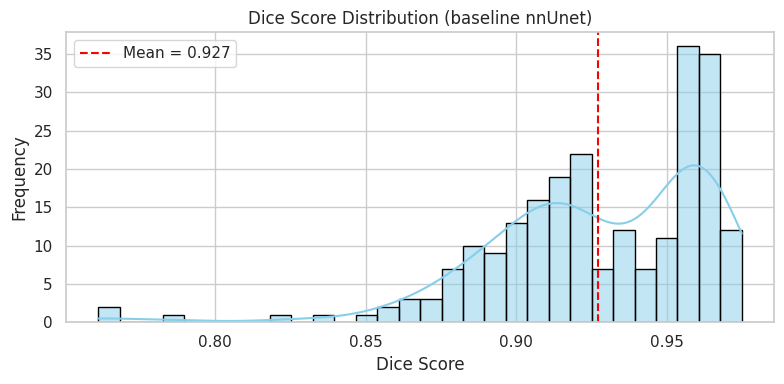

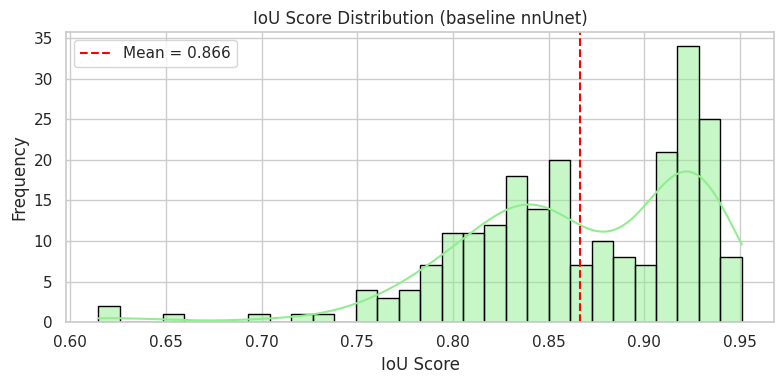

Dice Percentiles:
0.25    0.905790
0.50    0.928826
0.75    0.959193
0.90    0.965533
0.95    0.967808
Name: dice, dtype: float64

IoU Percentiles:
0.25    0.827803
0.50    0.867111
0.75    0.921586
0.90    0.933364
0.95    0.937625
Name: iou, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_fp = "/content/drive/MyDrive/data/Baseline_result/metrics_summary.csv"
df = pd.read_csv(csv_fp)

# 图像风格
sns.set(style="whitegrid")

#  Dice 分布图
plt.figure(figsize=(8, 4))
sns.histplot(df["dice"], kde=True, bins=30, color="skyblue", edgecolor="black")
plt.title("Dice Score Distribution (baseline nnUnet)")
plt.xlabel("Dice Score")
plt.ylabel("Frequency")
plt.axvline(df["dice"].mean(), color="red", linestyle="--", label=f"Mean = {df['dice'].mean():.3f}")
plt.legend()
plt.tight_layout()
plt.show()

# IoU 分布图
plt.figure(figsize=(8, 4))
sns.histplot(df["iou"], kde=True, bins=30, color="lightgreen", edgecolor="black")
plt.title("IoU Score Distribution (baseline nnUnet)")
plt.xlabel("IoU Score")
plt.ylabel("Frequency")
plt.axvline(df["iou"].mean(), color="red", linestyle="--", label=f"Mean = {df['iou'].mean():.3f}")
plt.legend()
plt.tight_layout()
plt.show()


print("Dice Percentiles:")
print(df["dice"].quantile([0.25, 0.5, 0.75, 0.9, 0.95]))

print("\nIoU Percentiles:")
print(df["iou"].quantile([0.25, 0.5, 0.75, 0.9, 0.95]))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


csv_fp = "/content/drive/MyDrive/data/Baseline_result/metrics_summary.csv"


df = pd.read_csv(csv_fp)

sns.set(style="whitegrid")

# 绘制 Dice 分布图
plt.figure(figsize=(8, 4))
sns.histplot(df["dice"], kde=True, bins=30, color="skyblue", edgecolor="black")
plt.title("Dice Score Distribution")
plt.xlabel("Dice Score")
plt.ylabel("Frequency")
plt.axvline(df["dice"].mean(), color="red", linestyle="--", label=f"Mean = {df['dice'].mean():.3f}")
plt.legend()
plt.tight_layout()
plt.show()

# 绘制 IoU 分布图
plt.figure(figsize=(8, 4))
sns.histplot(df["iou"], kde=True, bins=30, color="lightgreen", edgecolor="black")
plt.title("IoU Score Distribution")
plt.xlabel("IoU Score")
plt.ylabel("Frequency")
plt.axvline(df["iou"].mean(), color="red", linestyle="--", label=f"Mean = {df['iou'].mean():.3f}")
plt.legend()
plt.tight_layout()
plt.show()

# 打印分位数信息
print("Dice Percentiles:")
print(df["dice"].quantile([0.25, 0.5, 0.75, 0.9, 0.95]))

print("\nIoU Percentiles:")
print(df["iou"].quantile([0.25, 0.5, 0.75, 0.9, 0.95]))

In [ ]:



from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os, shutil, random, subprocess, textwrap, warnings
from pathlib import Path
import numpy as np, nibabel as nib, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


DRIVE_ROOT      = Path("/content/drive/MyDrive/data")  #  data 目录
BASE_LABEL_DIR  = DRIVE_ROOT/"gan_data"/"Synthetic_dataset_random_labels"
DATASET         = "Dataset232_BraTS_2023_rGANs"
TRAINER         = "nnUNetTrainer__nnUNetPlans__3d_fullres"
FOLDS           = ["0","1","2","3","4"]

os.environ.update({
    "nnUNet_raw":          "/content/nnUNet_raw",
    "nnUNet_preprocessed": "/content/nnUNet_preprocessed",
    "nnUNet_results":      "/content/nnUNet_results",
    "RESULTS_FOLDER":      "/content/nnUNet_results",
})


all_cases   = sorted([d.name for d in BASE_LABEL_DIR.iterdir() if d.is_dir()])
sample_cases= random.sample(all_cases, k=min(6,len(all_cases)))
print("Selected cases:", sample_cases, '\n')

RAW_TS = Path(os.environ["nnUNet_raw"])/DATASET/"imagesTs"
shutil.rmtree(RAW_TS, ignore_errors=True); RAW_TS.mkdir(parents=True, exist_ok=True)

MOD_MAP = {"t1ce":"0000","t1":"0001","t2":"0002","flair":"0003"}
for c in sample_cases:
    for mod,idx in MOD_MAP.items():
        f = BASE_LABEL_DIR/c/f"{c}-scan_{mod}.nii.gz"
        if f.exists():
            (RAW_TS/f"{c}_{idx}.nii.gz").symlink_to(f.resolve())
print("imagesTs →", RAW_TS, '\n')


PREP = Path(os.environ["nnUNet_preprocessed"])/DATASET
PREP.mkdir(parents=True, exist_ok=True)
for fn in ["dataset.json","plans.json"]:
    shutil.copy(DRIVE_ROOT/fn, PREP/fn)

RES = Path(os.environ["nnUNet_results"])/DATASET/TRAINER
for k in FOLDS:
    fd = RES/f"fold_{k}"; fd.mkdir(parents=True, exist_ok=True)
    shutil.copy(DRIVE_ROOT/f"fold_{k}"/"checkpoint_final.pth", fd/"checkpoint_final.pth")
    for fn in ["dataset.json","plans.json"]:
        shutil.copy(DRIVE_ROOT/fn, RES/fn)


PRED_DIR = Path("/content/pred"); shutil.rmtree(PRED_DIR, ignore_errors=True)
device = "cuda" if Path("/usr/bin/nvidia-smi").exists() else "cpu"

cmd = textwrap.dedent(f"""
nnUNetv2_predict -i {RAW_TS} -o {PRED_DIR} -d {DATASET} -c 3d_fullres \
                 -f {' '.join(FOLDS)} -device {device}
""").strip()
print("Running:\n", cmd, "\n")
subprocess.run(cmd, shell=True, check=True)
print("\nInference finished ➜", PRED_DIR, '\n')


def dice_iou(pred, gt):
    tp=(pred&gt).sum(); fp=(pred&(~gt)).sum(); fn=((~pred)&gt).sum()
    d=2*tp/(2*tp+fp+fn+1e-8); j=tp/(tp+fp+fn+1e-8); return d,j

records=[]
for c in sample_cases:
    pred=nib.load(PRED_DIR/f"{c}.nii.gz").get_fdata().astype(bool)
    gt  =nib.load(BASE_LABEL_DIR/c/f"{c}-seg.nii.gz").get_fdata().astype(bool)
    d,j = dice_iou(pred,gt); records.append(dict(case=c,dice=d,iou=j))

df=pd.DataFrame(records).round(4)
print(df,'\n', "Avg  Dice={:.4f}  IoU={:.4f}".format(df.dice.mean(), df.iou.mean()))


for c in sample_cases:
    img  = nib.load(BASE_LABEL_DIR/c/f"{c}-scan_flair.nii.gz").get_fdata()
    gt   = nib.load(BASE_LABEL_DIR/c/f"{c}-seg.nii.gz").get_fdata()>0
    pred = nib.load(PRED_DIR/f"{c}.nii.gz").get_fdata()>0
    z = img.shape[2]//2
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(img[:,:,z].T,cmap='gray',origin='lower'); plt.title(f'{c}\nFLAIR'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(img[:,:,z].T,cmap='gray',origin='lower'); plt.imshow(gt[:,:,z].T,cmap='Greens',alpha=.4,origin='lower');  plt.title('Ground-Truth'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(img[:,:,z].T,cmap='gray',origin='lower'); plt.imshow(pred[:,:,z].T,cmap='Reds',alpha=.4,origin='lower'); plt.title('Ensemble Pred'); plt.axis('off')
    plt.suptitle(f"Dice={df[df.case==c].dice.values[0]:.3f}   IoU={df[df.case==c].iou.values[0]:.3f}")
    plt.tight_layout(); plt.show()

Mounted at /content/drive
Selected cases: ['BraTS-GLI-00820-000_real_label_23', 'BraTS-GLI-00823-000_fake_label_60', 'BraTS-GLI-00820-000_real_label_5', 'BraTS-GLI-00823-000_fake_label_69', 'BraTS-GLI-00819-000_real_label_54', 'BraTS-GLI-00824-000_real_label_8'] 

imagesTs → /content/nnUNet_raw/Dataset232_BraTS_2023_rGANs/imagesTs 

Running:
 nnUNetv2_predict -i /content/nnUNet_raw/Dataset232_BraTS_2023_rGANs/imagesTs -o /content/pred -d Dataset232_BraTS_2023_rGANs -c 3d_fullres                  -f 0 1 2 3 4 -device cpu 



CalledProcessError: Command 'nnUNetv2_predict -i /content/nnUNet_raw/Dataset232_BraTS_2023_rGANs/imagesTs -o /content/pred -d Dataset232_BraTS_2023_rGANs -c 3d_fullres                  -f 0 1 2 3 4 -device cpu' returned non-zero exit status 127.

Selected cases: ['BraTS-GLI-00824-000_fake_label_48', 'BraTS-GLI-00824-000_fake_label_9', 'BraTS-GLI-00824-000_real_label_62']


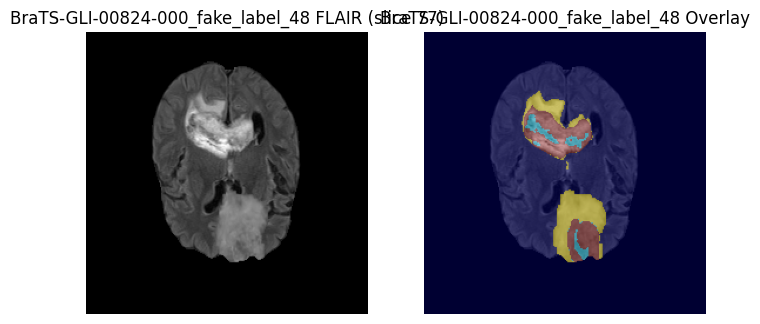

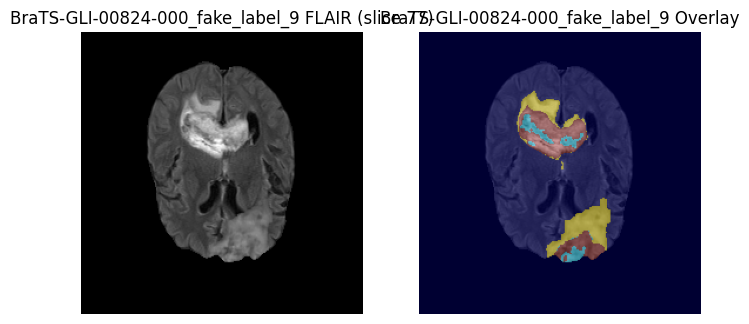

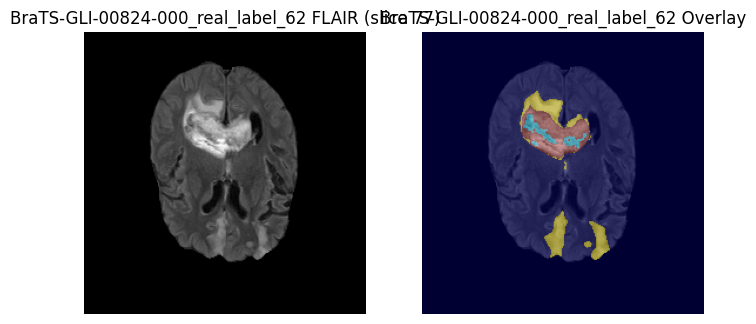

In [ ]:
import os, random
import nibabel as nib
import matplotlib.pyplot as plt

BASE_DIR = '/content/drive/MyDrive/data/gan_data/Synthetic_dataset_random_labels'

all_cases = sorted([d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))])
selected = random.sample(all_cases, k=min(3, len(all_cases)))
print("Selected cases:", selected)

for case in selected:
    case_dir = os.path.join(BASE_DIR, case)
    flair_path = os.path.join(case_dir, f"{case}-scan_flair.nii.gz")
    seg_path   = os.path.join(case_dir, f"{case}-seg.nii.gz")
    flair_img = nib.load(flair_path).get_fdata()
    seg_img   = nib.load(seg_path).get_fdata()
    z = flair_img.shape[2] // 2

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(flair_img[:,:,z].T, cmap='gray', origin='lower')
    plt.title(f"{case} FLAIR (slice {z})")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(flair_img[:,:,z].T, cmap='gray', origin='lower')
    plt.imshow(seg_img[:,:,z].T, cmap='jet', alpha=0.4, origin='lower')
    plt.title(f"{case} Overlay")
    plt.axis('off')

    plt.show()

正在扫描文件夹: /content/drive/MyDrive/data/gan_data/Synthetic_dataset_random_labels

✅ 成功找到 148 个 'real_label' 案例：
  - BraTS-GLI-00819-000_real_label_45
  - BraTS-GLI-00819-000_real_label_47
  - BraTS-GLI-00819-000_real_label_48
  - BraTS-GLI-00819-000_real_label_51
  - BraTS-GLI-00819-000_real_label_52
  - BraTS-GLI-00819-000_real_label_54
  - BraTS-GLI-00819-000_real_label_55
  - BraTS-GLI-00819-000_real_label_56
  - BraTS-GLI-00819-000_real_label_60
  - BraTS-GLI-00819-000_real_label_63
  - BraTS-GLI-00819-000_real_label_68
  - BraTS-GLI-00819-000_real_label_7
  - BraTS-GLI-00819-000_real_label_72
  - BraTS-GLI-00819-000_real_label_73
  - BraTS-GLI-00819-000_real_label_76
  - BraTS-GLI-00819-000_real_label_78
  - BraTS-GLI-00819-000_real_label_81
  - BraTS-GLI-00819-000_real_label_84
  - BraTS-GLI-00819-000_real_label_85
  - BraTS-GLI-00819-000_real_label_86
  - BraTS-GLI-00819-000_real_label_87
  - BraTS-GLI-00819-000_real_label_88
  - BraTS-GLI-00819-000_real_label_89
  - BraTS-GLI-0081

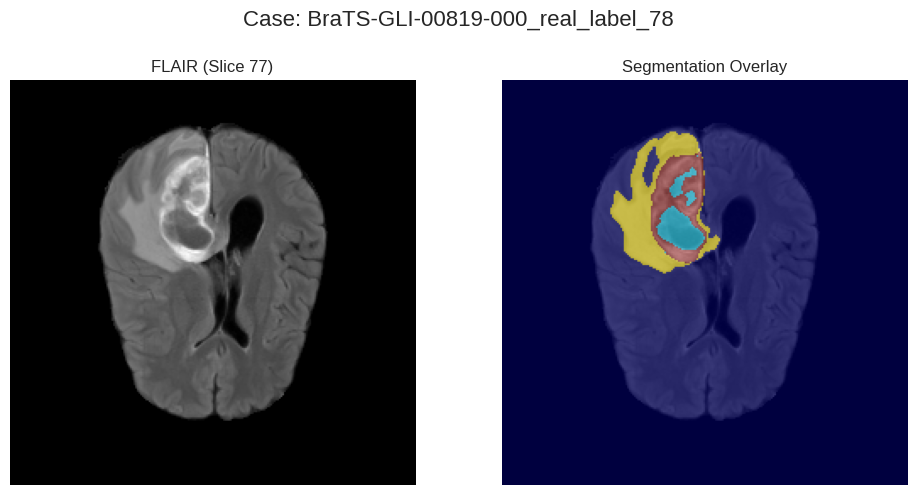

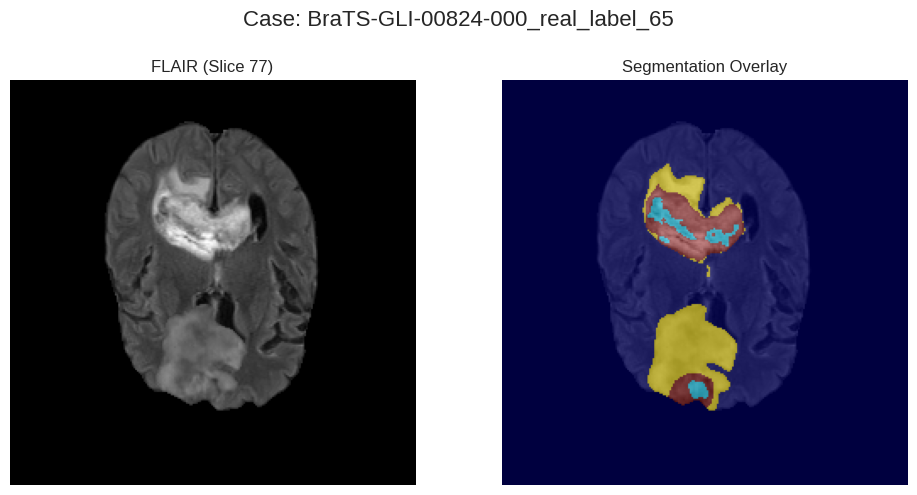

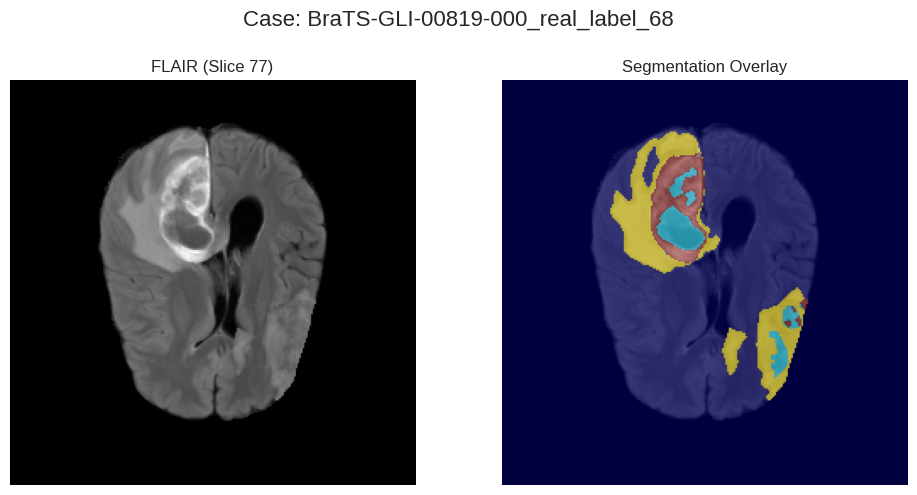

In [ ]:
import os
import random
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# --- 1. 配置您的数据文件夹路径 ---
# 请确保这个路径是正确的
BASE_DIR = Path('/content/drive/MyDrive/data/gan_data/Synthetic_dataset_random_labels')

print(f"正在扫描文件夹: {BASE_DIR}\n")

# --- 2. 查找并筛选所有 "real_label" 案例 ---
# 确保基础目录存在
if not BASE_DIR.exists():
    print(f"❌ 错误：找不到指定的文件夹路径！请检查 `BASE_DIR` 是否正确。")
else:
    # 遍历所有子目录，筛选出名字中包含 'real_label' 的案例
    all_cases = [d.name for d in BASE_DIR.iterdir() if d.is_dir()]
    real_cases = sorted([case for case in all_cases if 'real_label' in case])

    if not real_cases:
        print("未找到任何文件名包含 'real_label' 的案例。")
    else:
        print(f"✅ 成功找到 {len(real_cases)} 个 'real_label' 案例：")
        # 打印所有找到的案例名称
        for case_name in real_cases:
            print(f"  - {case_name}")

        # --- 3. 随机抽样并进行可视化展示 ---
        print("\n-------------------------------------------")
        print("正在随机抽样几个案例进行可视化展示...")
        print("-------------------------------------------")

        # 随机选择最多3个案例进行展示
        num_to_visualize = min(3, len(real_cases))
        selected_cases = random.sample(real_cases, k=num_to_visualize)

        print(f"已随机选择以下案例进行展示: {selected_cases}\n")

        for case in selected_cases:
            case_dir = BASE_DIR / case
            flair_path = case_dir / f"{case}-scan_flair.nii.gz"
            seg_path   = case_dir / f"{case}-seg.nii.gz"

            # 检查文件是否存在
            if not flair_path.exists() or not seg_path.exists():
                print(f"❗ 警告: 案例 '{case}' 中缺少FLAIR或分割文件，跳过可视化。")
                continue

            # 加载NIfTI图像数据
            flair_img = nib.load(flair_path).get_fdata()
            seg_img   = nib.load(seg_path).get_fdata()

            # 选择中间的切片进行2D展示
            z = flair_img.shape[2] // 2

            # 使用Matplotlib绘图
            plt.style.use('seaborn-v0_8-whitegrid') # 使用一个干净的绘图风格
            fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

            # 左图：原始FLAIR图像
            axes[0].imshow(flair_img[:,:,z].T, cmap='gray', origin='lower')
            axes[0].set_title(f"FLAIR (Slice {z})")
            axes[0].axis('off')

            # 右图：FLAIR图像上叠加分割标签
            axes[1].imshow(flair_img[:,:,z].T, cmap='gray', origin='lower')
            # 使用'jet'或'viridis'等彩色图谱，并设置透明度
            axes[1].imshow(seg_img[:,:,z].T, cmap='jet', alpha=0.5, origin='lower')
            axes[1].set_title(f"Segmentation Overlay")
            axes[1].axis('off')

            fig.suptitle(f"Case: {case}", fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

In [ ]:
import os
import math
import time
import shutil
import subprocess
import textwrap
import warnings
import logging
import sys
from pathlib import Path
from tqdm import tqdm
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ===============================================================
#  1. Path and Parameter Configuration
# ===============================================================
DRV_ROOT   = Path("/content/drive/MyDrive/data")
SRC_DIR    = DRV_ROOT / "gan_data" / "Synthetic_dataset_random_labels"
OUT_DIR    = DRV_ROOT / "Baseline_result"
OUT_DIR.mkdir(exist_ok=True)

DATASET    = "Dataset232_BraTS_2023_rGANs"
TRAINER    = "nnUNetTrainer__nnUNetPlans__3d_fullres"
FOLDS      = ["0", "1", "2", "3", "4"]
MODALITY   = "flair" # For visualization
MOD_MAP    = {"t1ce":"0000", "t1":"0001", "t2":"0002", "flair":"0003"}

# nnU-Net Environment Variables
os.environ.update({
    "nnUNet_raw":          "/content/nnUNet_raw",
    "nnUNet_preprocessed": "/content/nnUNet_preprocessed",
    "nnUNet_results":      "/content/nnUNet_results",
    "RESULTS_FOLDER":      "/content/nnUNet_results",
})

# ===============================================================
#  2. Setup Logging
# ===============================================================
log_fp = OUT_DIR / "pipeline.log"
logger = logging.getLogger("pipeline_logger")
logger.setLevel(logging.INFO)
logger.handlers.clear()
for h in (logging.StreamHandler(sys.stdout), logging.FileHandler(log_fp, encoding="utf-8")):
    h.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))
    logger.addHandler(h)
logger.info("=== New Inference and Scoring Session Started ===")

# ===============================================================
#  3. Prepare Metrics CSV (resumes if it exists)
# ===============================================================
csv_fp = OUT_DIR / "metrics_summary.csv"
if csv_fp.exists():
    try:
        done_cases = set(pd.read_csv(csv_fp)["case"])
    except (pd.errors.EmptyDataError, KeyError):
        csv_fp.write_text("case,dice,iou,inf_seconds\n")
        done_cases = set()
else:
    csv_fp.write_text("case,dice,iou,inf_seconds\n")
    done_cases = set()

# ===============================================================
#  4. Select Cases to Process
# ===============================================================
all_cases  = sorted([d.name for d in SRC_DIR.iterdir() if d.is_dir()])
# Select the last 15% of cases that have not been processed yet
cases_to_process = [c for c in all_cases if c not in done_cases]
n_last = math.ceil(len(cases_to_process) * 0.15)
todo_cases = cases_to_process[-n_last:] if n_last > 0 else []

logger.info(f"Total cases in source: {len(all_cases)}. Previously completed: {len(done_cases)}.")
if not todo_cases:
    logger.info("No new cases to process. Exiting.")
    sys.exit()
logger.info(f"This session will process {len(todo_cases)} cases.")

# ===============================================================
#  5. Prepare nnU-Net Directories and Files
# ===============================================================
# Link source images to nnUNet_raw
RAW_TS = Path(os.environ["nnUNet_raw"]) / DATASET / "imagesTs"
shutil.rmtree(RAW_TS, ignore_errors=True)
RAW_TS.mkdir(parents=True, exist_ok=True)
for case in tqdm(todo_cases, desc="Linking source images"):
    for mod, idx in MOD_MAP.items():
        src = SRC_DIR / case / f"{case}-scan_{mod}.nii.gz"
        if src.exists():
            (RAW_TS / f"{case}_{idx}.nii.gz").symlink_to(src.resolve())

# Copy necessary files to preprocessed and results directories
PREP_DIR = Path(os.environ["nnUNet_preprocessed"]) / DATASET
RES_BASE_DIR = Path(os.environ["nnUNet_results"]) / DATASET / TRAINER
PREP_DIR.mkdir(parents=True, exist_ok=True)
RES_BASE_DIR.mkdir(parents=True, exist_ok=True)

for fn in ("dataset.json", "plans.json"):
    src_file = DRV_ROOT / fn
    if src_file.exists():
        shutil.copy(src_file, PREP_DIR / fn)
        shutil.copy(src_file, RES_BASE_DIR / fn)
        logger.info(f"Copied {fn} to required directories.")
    else:
        logger.error(f"Source file {src_file} is missing!")

# Copy model checkpoints with integrity check
for k in FOLDS:
    fold_dir = RES_BASE_DIR / f"fold_{k}"
    fold_dir.mkdir(parents=True, exist_ok=True)
    src_ckpt = DRV_ROOT / f"fold_{k}" / "checkpoint_final.pth"
    dst_ckpt = fold_dir / "checkpoint_final.pth"

    if not src_ckpt.exists():
        logger.error(f"Fold {k}: Source checkpoint missing: {src_ckpt}")
        continue

    shutil.copy(src_ckpt, dst_ckpt)
    if not dst_ckpt.exists() or src_ckpt.stat().st_size != dst_ckpt.stat().st_size:
        logger.error(f"Fold {k}: Checkpoint copy failed or size mismatch!")
    else:
        logger.info(f"Fold {k}: Checkpoint copied successfully.")

# ===============================================================
#  6. Run Inference
# ===============================================================
PRED_DIR = OUT_DIR / "preds"
PRED_DIR.mkdir(exist_ok=True) # Don't remove if resuming

device = "cuda" if Path("/usr/bin/nvidia-smi").exists() else "cpu"
cmd = (
    f"nnUNetv2_predict -i {RAW_TS} -o {PRED_DIR} "
    f"-d {DATASET} -c 3d_fullres -f {' '.join(FOLDS)} -device {device} --disable_tta"
)
logger.info("Launching nnUNetv2_predict...")
start_time = time.time()
proc = subprocess.run(cmd, shell=True, capture_output=True, text=True)
elapsed_time = time.time() - start_time

if proc.returncode != 0:
    logger.error(f"nnUNetv2_predict FAILED with exit code: {proc.returncode}")
    logger.error(f"--- STDOUT ---\n{proc.stdout}")
    logger.error(f"--- STDERR ---\n{proc.stderr}")
    sys.exit("Inference failed. Check logs.")

logger.info(f"Inference complete. Total time: {elapsed_time:.2f} seconds.")

# ===============================================================
#  7. Score Results and Generate Visualizations
# ===============================================================
def dice_iou(pred, gt):
    tp = (pred & gt).sum()
    fp = (pred & ~gt).sum()
    fn = (~pred & gt).sum()
    return 2*tp/(2*tp+fp+fn+1e-8), tp/(tp+fp+fn+1e-8)

def append_to_csv(case, d, i, t):
    with open(csv_fp, "a") as f:
        f.write(f"{case},{d:.6f},{i:.6f},{t:.2f}\n")
        f.flush()
        os.fsync(f.fileno())

pred_files = [PRED_DIR / f"{case}.nii.gz" for case in todo_cases]
avg_inf_time = elapsed_time / len(pred_files) if pred_files else 0

for idx, pred_fp in enumerate(tqdm(pred_files, desc="Scoring and Visualizing"), 1):
    case = pred_fp.stem
    gt_fp = SRC_DIR / case / f"{case}-seg.nii.gz"
    img_fp = SRC_DIR / case / f"{case}-scan_{MODALITY}.nii.gz"

    if not (gt_fp.exists() and img_fp.exists()):
        logger.warning(f"Skipping {case}, missing source image or ground truth.")
        continue

    pred_data = nib.load(pred_fp).get_fdata().astype(bool)
    gt_data = nib.load(gt_fp).get_fdata().astype(bool)
    dice_score, iou_score = dice_iou(pred_data, gt_data)

    logger.info(f"[{idx}/{len(pred_files)}] {case:<35} Dice={dice_score:.4f} IoU={iou_score:.4f} AvgInferTime={avg_inf_time:.2f}s")
    append_to_csv(case, dice_score, iou_score, avg_inf_time)

    # Visualization
    img_data = nib.load(img_fp).get_fdata()
    z = img_data.shape[2] // 2
    img_slice = (img_data[:,:,z] - img_data[:,:,z].min()) / (img_data[:,:,z].ptp() + 1e-8)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
    fig.suptitle(f"Case: {case} | Dice: {dice_score:.3f}", fontsize=14)

    # Prediction Overlay
    axes[0].imshow(img_slice.T, cmap='gray', origin='lower')
    axes[0].imshow(pred_data[:,:,z].T, cmap='Reds', alpha=0.5, origin='lower')
    axes[0].set_title("Prediction")
    axes[0].axis("off")

    # Ground Truth Overlay
    axes[1].imshow(img_slice.T, cmap='gray', origin='lower')
    axes[1].imshow(gt_data[:,:,z].T, cmap='Greens', alpha=0.5, origin='lower')
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    # TP/FP/FN Overlap
    overlap_img = np.zeros((*img_slice.T.shape, 4))
    overlap_img[(pred_data[:,:,z].T) & (gt_data[:,:,z].T)] = [0, 1, 0, 0.7]  # TP: Green
    overlap_img[(pred_data[:,:,z].T) & (~gt_data[:,:,z].T)] = [1, 0, 0, 0.7] # FP: Red
    overlap_img[(~pred_data[:,:,z].T) & (gt_data[:,:,z].T)] = [0, 0, 1, 0.7] # FN: Blue
    axes[2].imshow(img_slice.T, cmap='gray', origin='lower')
    axes[2].imshow(overlap_img, origin='lower')
    axes[2].set_title("Overlap (TP:🟢, FP:🔴, FN:🔵)")
    axes[2].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    fig.savefig(OUT_DIR / f"{case}_overlay.png", bbox_inches="tight")
    plt.close(fig)

# ===============================================================
#  8. Final Summary
# ===============================================================
df_all = pd.read_csv(csv_fp)
logger.info(f"Session finished. Total scored cases in CSV: {len(df_all)}.")
logger.info(f"Cumulative Average Dice: {df_all.dice.mean():.4f}, IoU: {df_all.iou.mean():.4f}")

2025-07-22 04:48:03,297 - INFO - === New Inference and Scoring Session Started ===


INFO:pipeline_logger:=== New Inference and Scoring Session Started ===


2025-07-22 04:48:03,351 - INFO - Total cases in source: 296. Previously completed: 230.


INFO:pipeline_logger:Total cases in source: 296. Previously completed: 230.


2025-07-22 04:48:03,354 - INFO - This session will process 10 cases.


INFO:pipeline_logger:This session will process 10 cases.
Linking source images: 100%|██████████| 10/10 [00:00<00:00, 200.30it/s]

2025-07-22 04:48:03,417 - INFO - Copied dataset.json to required directories.



INFO:pipeline_logger:Copied dataset.json to required directories.


2025-07-22 04:48:03,425 - INFO - Copied plans.json to required directories.


INFO:pipeline_logger:Copied plans.json to required directories.


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


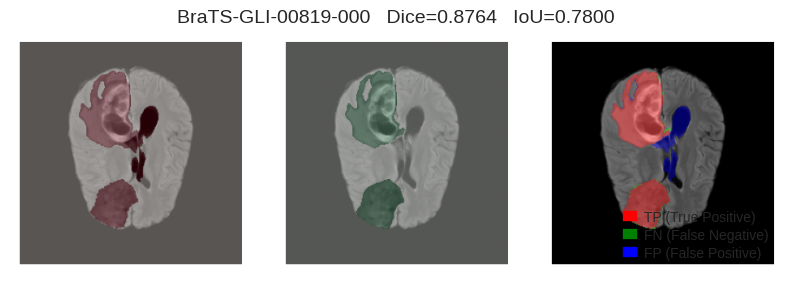

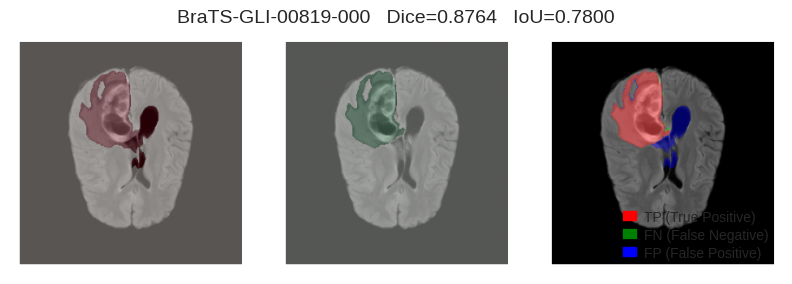

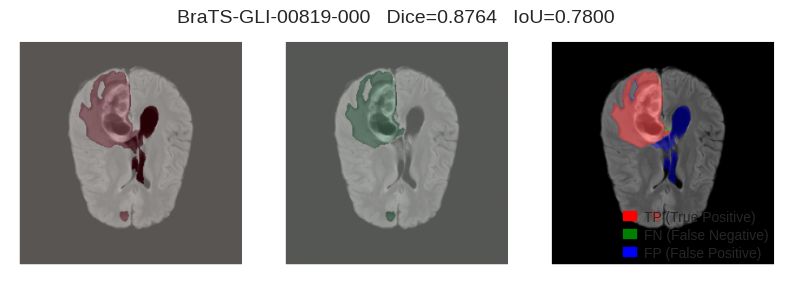

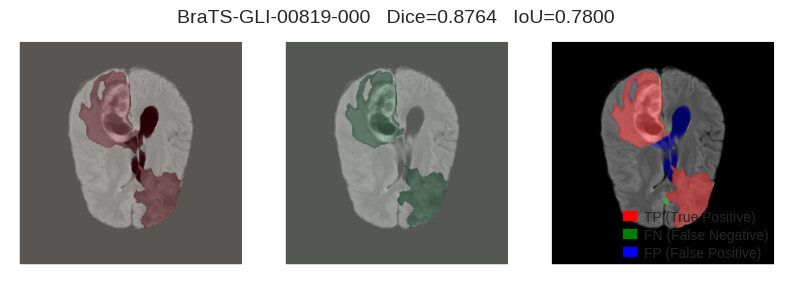

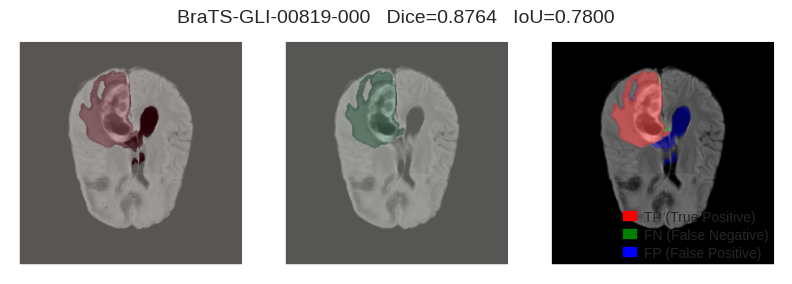

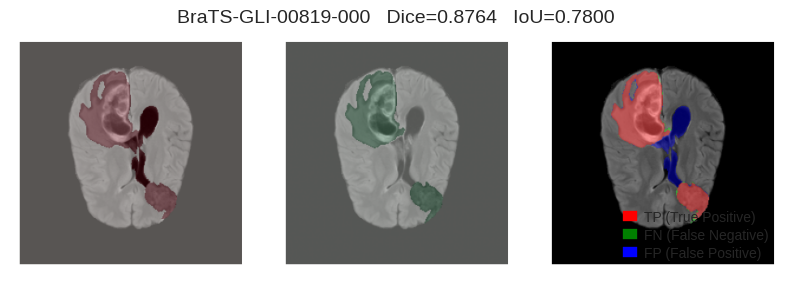

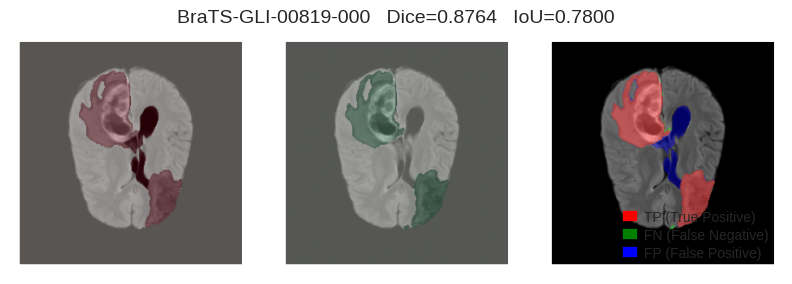

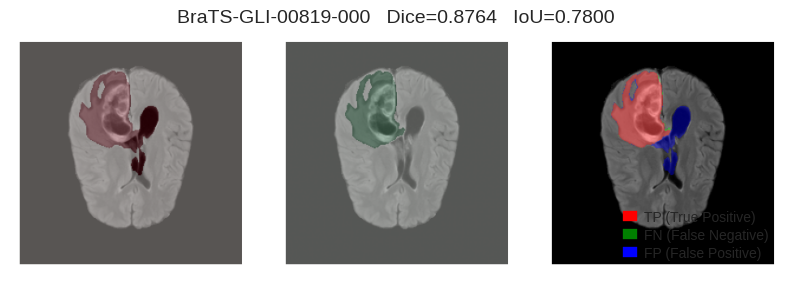

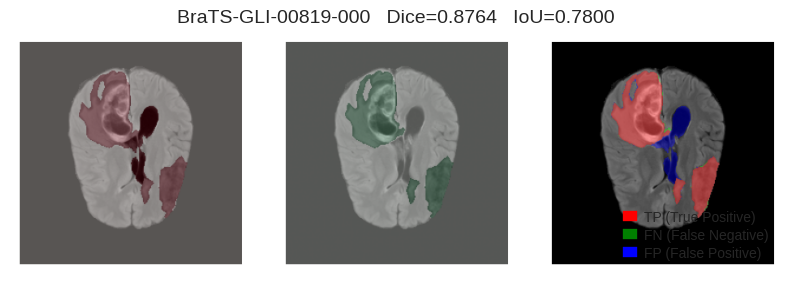

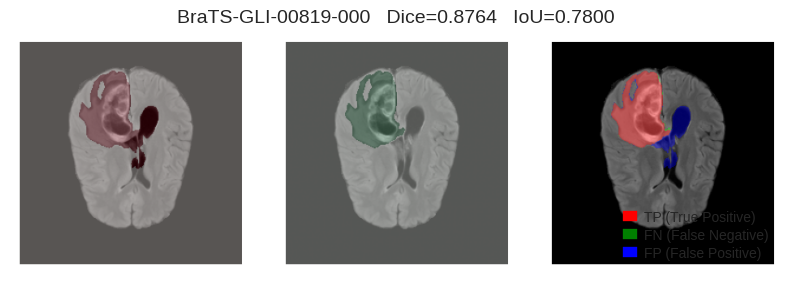

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import matplotlib.patches as mpatches

# ── 配置 ─────────────────────────────────────────────
BASE_DIR    = Path("/content/drive/MyDrive/data/Baseline_result")
METRICS_CSV = BASE_DIR / "metrics_summary.csv"

# ── 1. 获取前 10 张 real_label overlay.png ───────────────
overlay_files = sorted(BASE_DIR.glob("*_real_label_*_overlay.png"))[:10]

# ── 2. 读取指标表 ─────────────────────────────────────────
df = pd.read_csv(METRICS_CSV)

# ── 3. 定义 legend patch ─────────────────────────────────
tp_patch = mpatches.Patch(color='red',   label='TP (True Positive)')
fn_patch = mpatches.Patch(color='green', label='FN (False Negative)')
fp_patch = mpatches.Patch(color='blue',  label='FP (False Positive)')

# ── 4. 单独大图展示每张样本，并将 legend 放到图内 ─────────
for img_path in overlay_files:
    # 提取 case
    case = img_path.stem.split("_real_label")[0]
    match = df[df["case"].str.contains(case)]
    if not match.empty:
        dice, iou = match.iloc[0][["dice","iou"]]
        title = f"{case}   Dice={dice:.4f}   IoU={iou:.4f}"
    else:
        title = f"{case}   Dice/IoU N/A"

    # 加载图像
    img = plt.imread(str(img_path))

    # 4.1 放大画布
    fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.imshow(img)
    ax.axis("off")

    # 4.2 标题字体调小并紧贴图像
    ax.set_title(title, fontsize=14, pad=8)

    # 4.3 legend 放图内右下角，字体再小一点
    legend = ax.legend(
        handles=[tp_patch, fn_patch, fp_patch],
        loc="lower right",
        fontsize=10,
        framealpha=0.6,
        handlelength=1,
        handletextpad=0.5,
        borderpad=0.5,
        labelspacing=0.3
    )
    # 细化一下边框线宽
    legend.get_frame().set_linewidth(0.5)

    # 4.4 紧凑布局
    plt.tight_layout(pad=1)
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


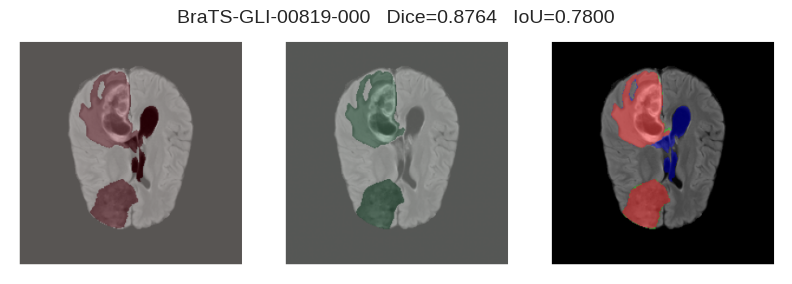

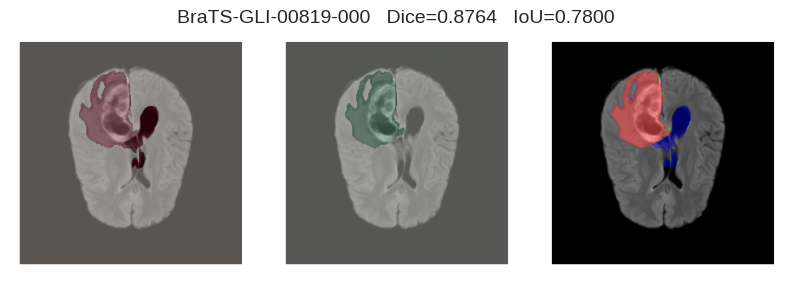

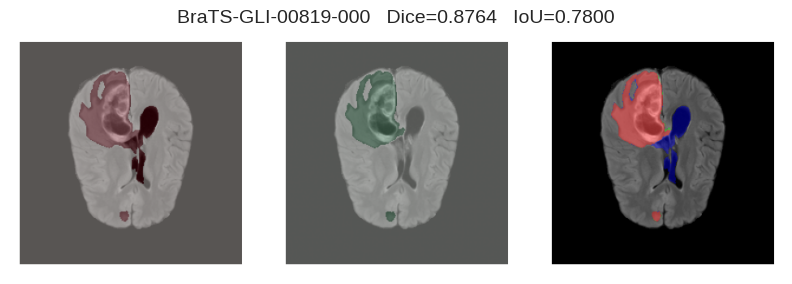

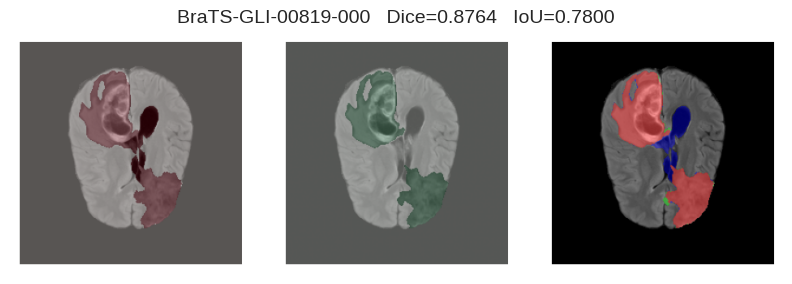

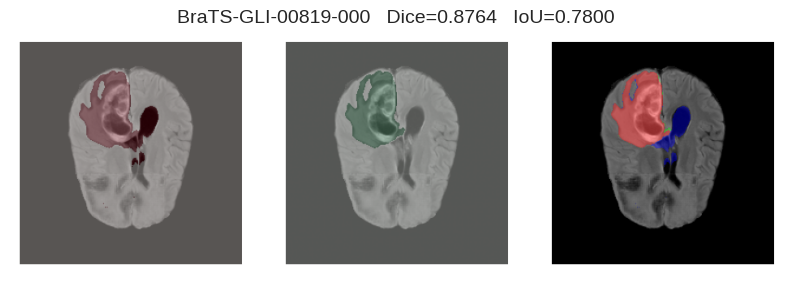

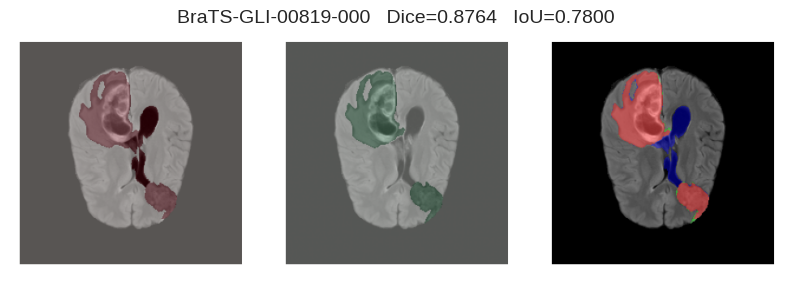

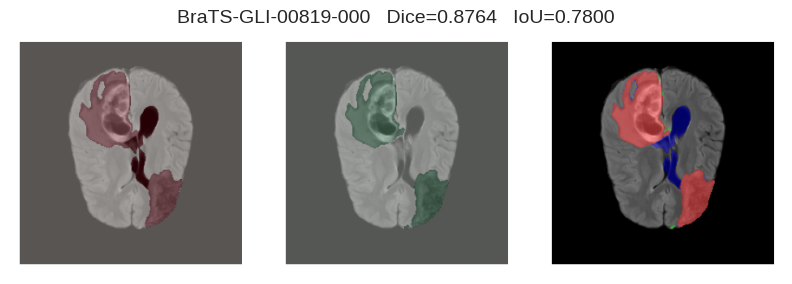

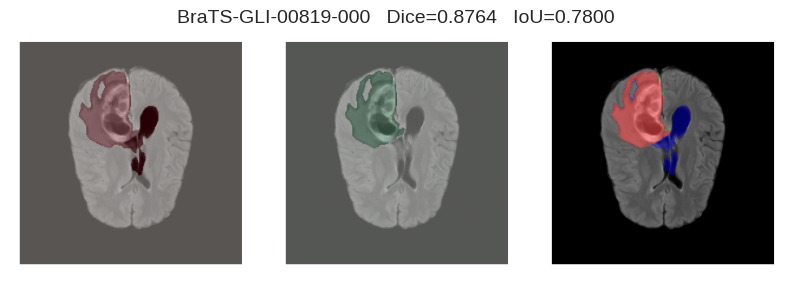

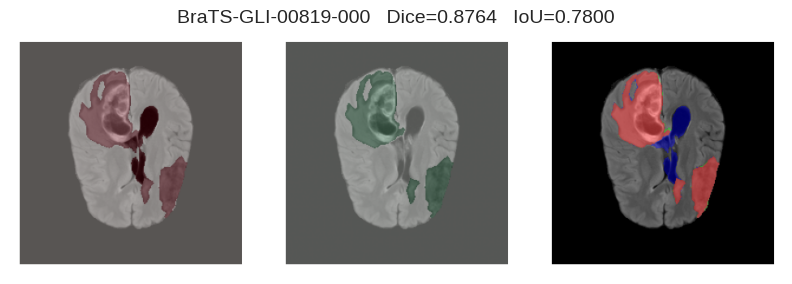

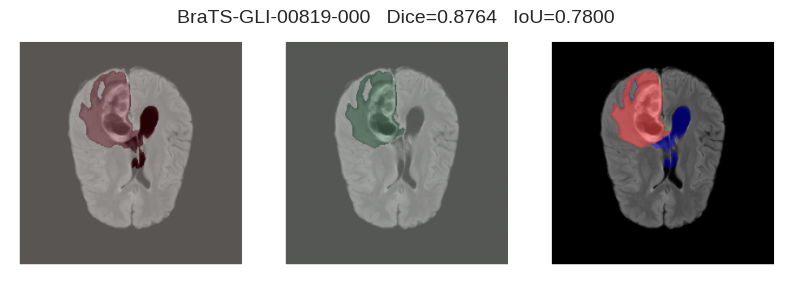

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# ── 配置 ─────────────────────────────────────────────
BASE_DIR    = Path("/content/drive/MyDrive/data/Baseline_result")
METRICS_CSV = BASE_DIR / "metrics_summary.csv"

# ── 1. 获取前 10 张 real_label overlay.png ───────────────
overlay_files = sorted(BASE_DIR.glob("*_real_label_*_overlay.png"))[:10]

# ── 2. 读取指标表 ─────────────────────────────────────────
df = pd.read_csv(METRICS_CSV)

# ── 3. 单独大图展示每张样本，不显示 legend ───────────────
for img_path in overlay_files:
    # 提取 case
    case = img_path.stem.split("_real_label")[0]
    match = df[df["case"].str.contains(case)]
    if not match.empty:
        dice, iou = match.iloc[0][["dice", "iou"]]
        title = f"{case}   Dice={dice:.4f}   IoU={iou:.4f}"
    else:
        title = f"{case}   Dice/IoU N/A"

    # 加载并显示 overlay 图片
    img = plt.imread(str(img_path))
    fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.imshow(img)
    ax.axis("off")

    # 添加标题
    ax.set_title(title, fontsize=14, pad=8)

    # 紧凑布局
    plt.tight_layout(pad=1)
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


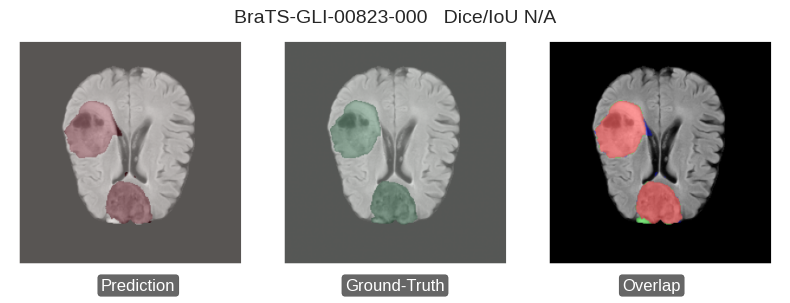

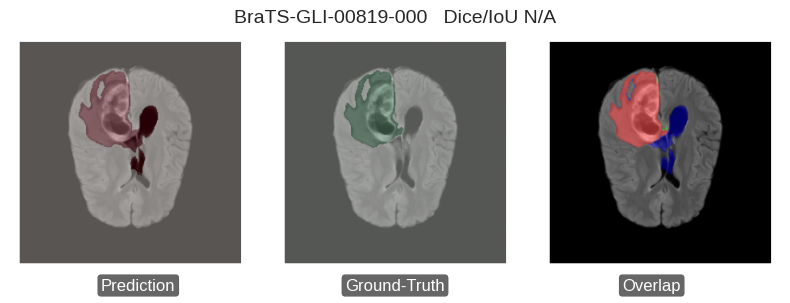

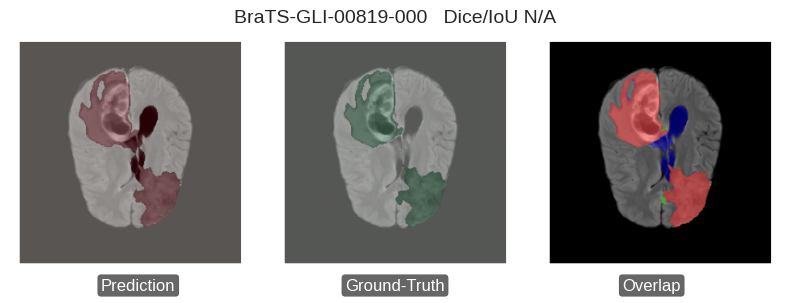

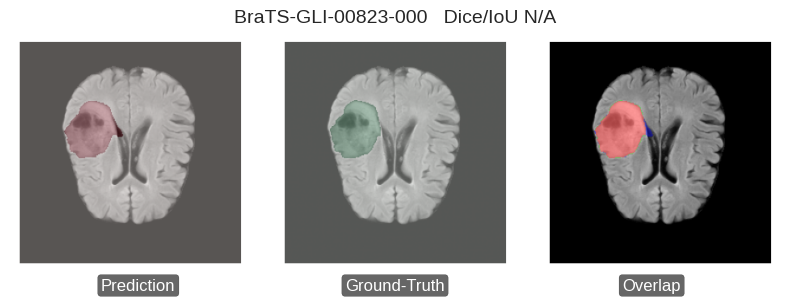

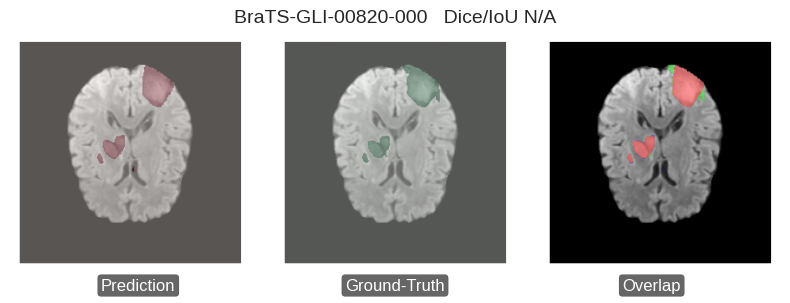

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import random
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# ── 配置 ─────────────────────────────────────────────
BASE_DIR    = Path("/content/drive/MyDrive/data/Baseline_result")
METRICS_CSV = BASE_DIR / "metrics_summary.csv"

# ── 1. 列出所有 real_label overlay.png ──────────────────
overlay_files = sorted(BASE_DIR.glob("*_real_label_*_overlay.png"))

# ── 2. 随机抽取 5 个（或改成你需要的数量） ─────────────────
random.seed(42)
sample_files = random.sample(overlay_files, k=min(5, len(overlay_files)))

# ── 3. 读取指标表 ─────────────────────────────────────────
df = pd.read_csv(METRICS_CSV)

# ── 4. 依次展示，每张 overlay 上方标注三子图含义 ───────────
for img_path in sample_files:
    # 提取 case & 指标
    case = img_path.stem.split("_real_label")[0]
    match = df[df["case"] == case]
    if not match.empty:
        dice, iou = match.iloc[0][["dice","iou"]]
        title_text = f"{case}   Dice={dice:.4f}   IoU={iou:.4f}"
    else:
        title_text = f"{case}   Dice/IoU N/A"

    # 加载 overlay PNG（它本身就是三子图合成的图）
    img = plt.imread(str(img_path))

    # 创建 Figure + Axes
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
    ax.imshow(img)
    ax.axis("off")

    # 主标题：case + 指标
    ax.set_title(title_text, fontsize=14, pad=8)

    # 在 overlay 的三等分位置，各自标注子图含义
    labels = ["Prediction", "Ground-Truth", "Overlap"]
    xs = [1/6, 3/6, 5/6]
    for x, lab in zip(xs, labels):
        ax.text(
            x, -0.02, lab,
            transform=ax.transAxes,
            ha="center", va="top",
            fontsize=12,
            color="white",
            bbox=dict(facecolor="black", alpha=0.6, boxstyle="round,pad=0.2")
        )

    plt.tight_layout()
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


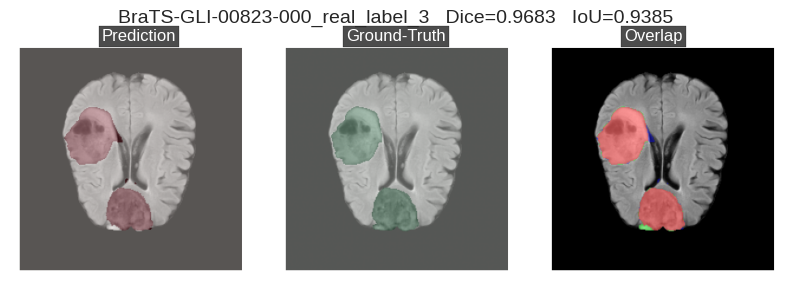

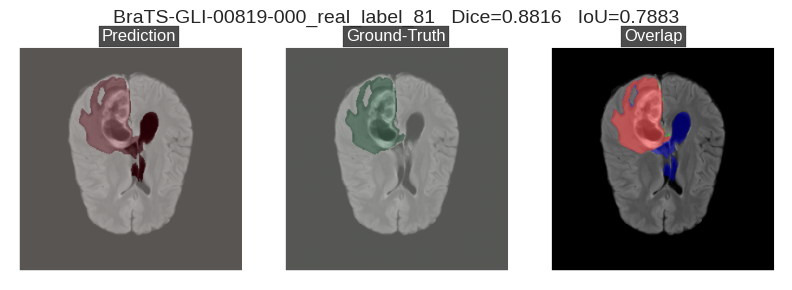

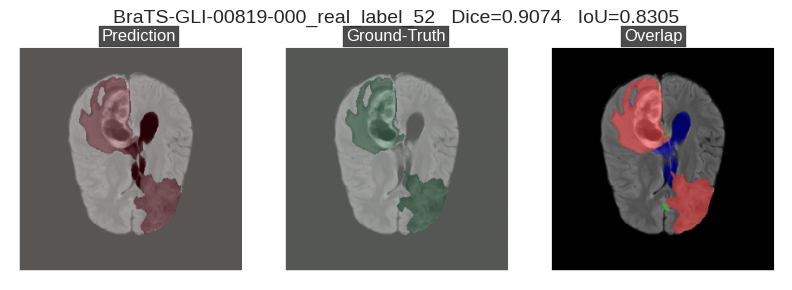

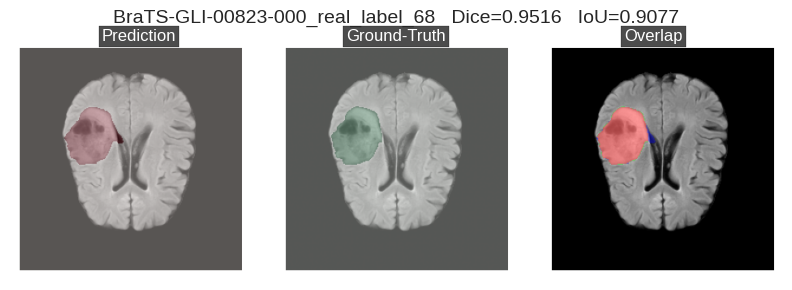

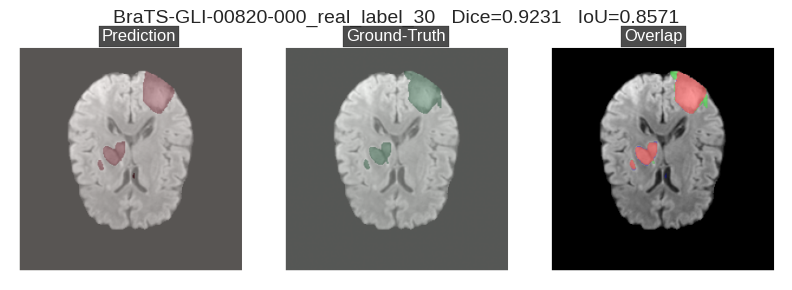

In [ ]:
from google.colab import drive
import random
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

drive.mount('/content/drive', force_remount=False)

BASE_DIR    = Path("/content/drive/MyDrive/data/Baseline_result")
METRICS_CSV = BASE_DIR / "metrics_summary.csv"
df          = pd.read_csv(METRICS_CSV)

# 所有 “real_label” overlay PNG 并随机抽样
overlay_files = sorted(BASE_DIR.glob("*_real_label_*_overlay.png"))
random.seed(42)
sample_files  = random.sample(overlay_files, k=min(5, len(overlay_files)))

# 逐一展示
for img_path in sample_files:
    case_key = img_path.stem.rsplit("_overlay", 1)[0]
    row = df[df["case"] == case_key]
    if not row.empty:
        dice = row.iloc[0]["dice"]
        iou  = row.iloc[0]["iou"]
        title_text = f"{case_key}   Dice={dice:.4f}   IoU={iou:.4f}"
    else:
        title_text = f"{case_key}   Dice/IoU N/A"

    img = plt.imread(str(img_path))
    fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
    ax.imshow(img)
    ax.axis("off")

    #  case + 指标
    ax.set_title(title_text, fontsize=14, pad=12)

    labels = ["Prediction", "Ground-Truth", "Overlap"]
    xs     = [1/6, 3/6, 5/6]
    for x, lab in zip(xs, labels):
        ax.text(
            x, 0.98, lab,
            transform=ax.transAxes,
            ha="center", va="bottom",
            fontsize=12,
            color="white",
            bbox=dict(facecolor="black", alpha=0.7, pad=2)
        )

    # 先 tight，然后把 top 调低到 0.80，空出更多上方空间
    plt.tight_layout(pad=1)
    plt.subplots_adjust(top=0.70)

    plt.show()

In [ ]:
df['']

0      BraTS-GLI-00819-000_real_label_45
1      BraTS-GLI-00819-000_real_label_47
2      BraTS-GLI-00819-000_real_label_48
3      BraTS-GLI-00819-000_real_label_51
4      BraTS-GLI-00819-000_real_label_52
                     ...                
225     BraTS-GLI-00823-000_real_label_9
226    BraTS-GLI-00823-000_real_label_92
227    BraTS-GLI-00823-000_real_label_94
228    BraTS-GLI-00823-000_real_label_96
229     BraTS-GLI-00824-000_fake_label_1
Name: case, Length: 230, dtype: object